### IMPORT PACKAGES AND INITIALIZE ENVIRONMENT

In [1]:
import copy
import datetime
import os
import re
from datetime import timedelta

import eikon as ek
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display
from bs4 import BeautifulSoup
from eikon import EikonError
import nltk
from nltk import pos_tag, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from scipy.stats import f, f_oneway, levene, ttest_1samp
from selenium.webdriver.support import expected_conditions as EC
from tqdm.notebook import tqdm
from wordcloud import WordCloud



nltk.download('punkt')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to C:\Users\Boyu
[nltk_data]     Wu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to C:\Users\Boyu
[nltk_data]     Wu\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

#### Init. Eikon environment

Set App Key accordingly and try a sinmpe query to check whether the Refinitiv Eikon environment is working correctly

In [2]:
try:
    # Set your AppKey obtained from the App Key Generator in the Eikon Desktop
    # You need to replace 'YOUR_APP_KEY' with your actual Eikon AppKey
    ek.set_app_key('41027605ec664032a2fd6e108f865e4209068a41')

    instrument = 'AAPL.O' 

    data = ek.get_data(instrument, fields=['TR.PriceClose', 'TR.Volume'])

    print("Market Data for", instrument)
    print(data)

except ek.EikonError as e:
    print("Eikon Error:", e)

    if "Eikon Proxy not running" in str(e):
        print("Please make sure the Eikon Desktop application is running.")

Market Data for AAPL.O
(  Instrument  Price Close    Volume
0     AAPL.O       224.72  46414013, None)


Initiate global parameters and queries which we use for the whole data collection process. 
Most important is the definition of the EURO STOXX 50 query (as expected with the length of 50) as well as the start and end date of the query. 

In [3]:
query_global = '0#.STOXX50E'
tickers = [
    "NOVOb.CO", "LVMH.PA", 
    "ASML.AS", "NESN.S", "HRMS.PA",
    "OREP.PA", "SHEL.AS", "SAPG.DE", "AZN.L", "NOVN.S",
    "ROG.S", "TTEF.PA", "HSBA.L", "SIEGn.DE", "AIR.PA",
    "SCHN.PA", "ULVR.L", "SASY.PA", "RIO.L", "DTEGn.DE",
    "ALVG.DE", "BP.L", "ABI.BR", "AIRP.PA", "ESLX.PA",
    "SAF.PA", "UBSG.S", "ABBN.S", "PRX.AS", "MBGn.DE",
    "GSK.L", "AXAF.PA", "BNPP.PA", "SAN.MC", "IBE.MC",
    "DGE.L", "REL.L", "CFR.S", "GLEN.L", "ZURN.S",
    "SGEF.PA", "ENEI.MI", "BATS.L", "CRDI.MI", "MUVGn.DE",
    "INGA.AS", "DHLn.DE", "BASFn.DE", "NG.L", "RKT.L"
]

# This can be used to finetune the data collection process - However in general can be kept as np.inf
number_of_news_to_pull = np.inf 
length_of_data = 0 



# One fact to keep in mind here while running the code is to restrict the date_to and x_month_ago to a short time (max. 1 month, preferably a week).
# Since Refinitiv Eikon Datastream limits the requests per day and else the code will not be able to run sucessfully.
date_to = datetime.datetime(2024, 2, 14, 23, 59, 59)  


x_months_ago = datetime.datetime(2024, 2, 1, 0, 0, 0) 
len(tickers)

50

Example of some stock movements

Error processing NOVOb.CO: 'NoneType' object has no attribute 'empty'


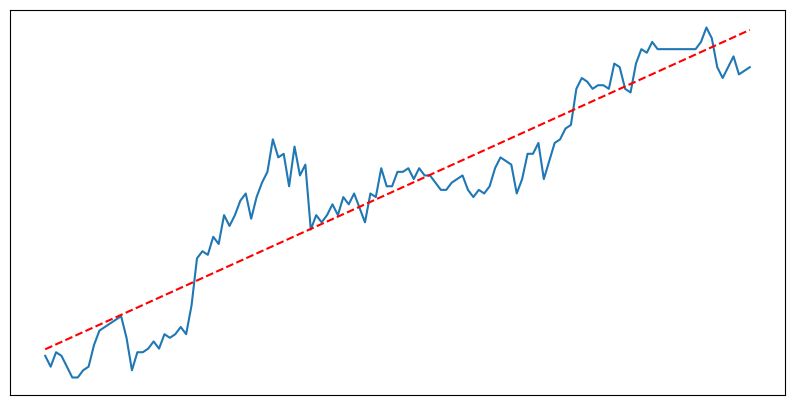

2024-08-16 11:01:58,757 P[5888] [MainThread 22884] UDF Core request failed. Gateway Time-out
2024-08-16 11:01:58,757 P[5888] [MainThread 22884] HTTP request failed: EikonError-UDF Core request failed. Gateway Time-out


Error processing ASML.AS: Error code 2504 | UDF Core request failed. Gateway Time-out
Error processing NESN.S: 'NoneType' object has no attribute 'empty'


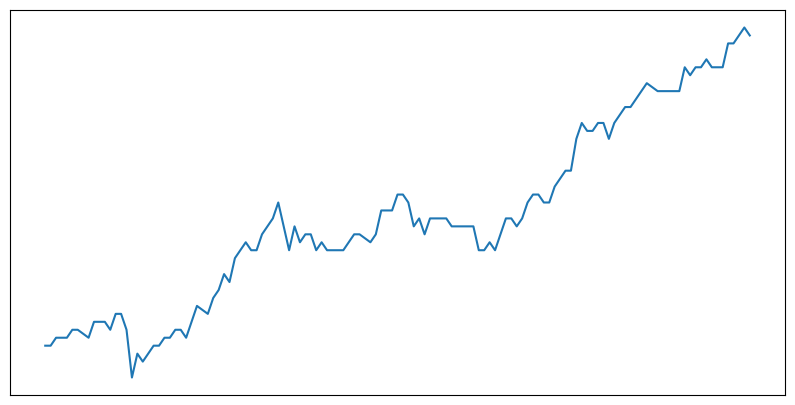

Error processing OREP.PA: 'NoneType' object has no attribute 'empty'


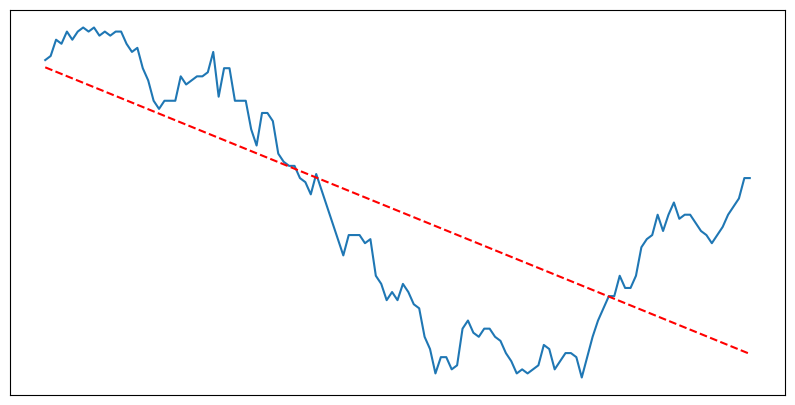

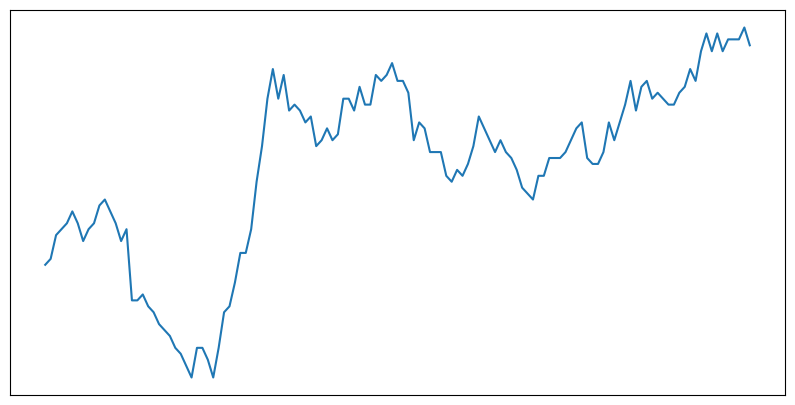

2024-08-16 11:02:35,011 P[5888] [MainThread 22884] UDF Core request failed. Gateway Time-out
2024-08-16 11:02:35,011 P[5888] [MainThread 22884] HTTP request failed: EikonError-UDF Core request failed. Gateway Time-out


Error processing AZN.L: Error code 2504 | UDF Core request failed. Gateway Time-out


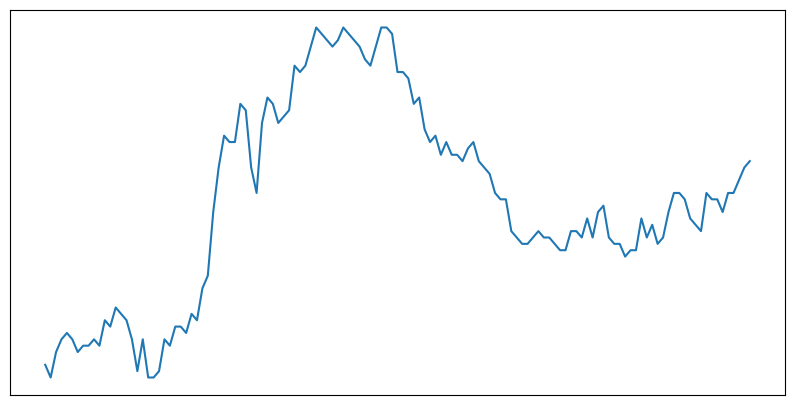

In [4]:
start_date = '2024-05-15 13:00:00'
end_date = '2024-05-15 15:10:00'

from sklearn.linear_model import LinearRegression

# Plot each ticker's data
for ticker in tickers[:5]:
    try:
        data = ek.get_timeseries(ticker, interval='minute', start_date=start_date, end_date=end_date)
        
        # Plot only if data is returned
        if not data.empty:
            plt.figure(figsize=(10, 5))
            plt.plot(data.index, data['CLOSE'], label=ticker)
            
            # Add the ticker name as the title
            # plt.title(f'{ticker}')
            plt.grid(True)
            plt.gca().axes.get_yaxis().set_visible(False)  # Hide y-axis
            plt.gca().axes.get_xaxis().set_visible(False)  # Hide x-axis
            
            # If ticker is LVMH.PA or ASML.AS, conduct linear regression
            if ticker in ['LVMH.PA', 'ASML.AS', 'SHEL.AS']:
                # Prepare the data for linear regression
                X = np.arange(len(data)).reshape(-1, 1)  # Time steps as the independent variable
                y = data['CLOSE'].values  # Closing prices as the dependent variable
                
                # Perform linear regression
                model = LinearRegression()
                model.fit(X, y)
                y_pred = model.predict(X)
                
                # Plot the linear regression line in red dotted style
                plt.plot(data.index, y_pred, 'r--', label=f'{ticker} Linear Regression')
            
            plt.show()
    except Exception as e:
        print(f"Error processing {ticker}: {e}")
        pass

### CREATE DATAFRAME
Method retrieves and processes news headlines for given stock tickers using a specified sentiment analysis algorithm, concatenating results into a single DataFrame.

In [5]:
def request_news_dataframe(query = "DBKGn.DE", algorithm = "SentimentIntensityAnalyzer",read_allowed = False, date_to = date_to, x_months_ago = x_months_ago):

    file_name = "snapshot.csv"
    
    if os.path.exists(file_name) and read_allowed == True:
        
        raw_data_df = pd.read_csv("snapshot.csv",  index_col=0)

    else:
        news_query = "R:" + str(query) + " AND Language:LEN"


        
        count_per_batch = 100  # Number of news articles to retrieve per batch - 100 is max the dataplatform allows
        total_count = number_of_news_to_pull  # Total number of news articles to retrieve



        all_news_headlines = []

        date_to_str = str(date_to) 


        while len(all_news_headlines) < total_count: 
            print(date_to)
            print(x_months_ago)
            if date_to.replace(tzinfo=None) <= x_months_ago:
                print('Interrupt')
                return pd.DataFrame(all_news_headlines)


            remaining_count = total_count - len(all_news_headlines)
            current_batch_count = str(min(count_per_batch, remaining_count))
            
            if date_to is None:
                headlines = ek.send_json_request("News_Headlines",
                                        {
                                            'number': current_batch_count, 
                                            'query': news_query,
                                            # 'dateTo': '2023-12-21T12:00:00',
                                            # 'repository':'NewsWire,NewsRoom,WebNews'
                                            'repository':'NewsWire,NewsRoom'
                                        })
                news_headlines = ek.news_request.get_data_frame(headlines)
            else:
                date_to_str = str(date_to)  # Convert Timestamp to string
                headlines = ek.send_json_request("News_Headlines",
                                        {
                                            'number': current_batch_count, 
                                            'query': news_query,
                                            'dateTo': date_to_str,
                                            # 'repository':'NewsWire,NewsRoom,WebNews'
                                            'repository':'NewsWire,NewsRoom'

                                        })
                news_headlines = ek.news_request.get_data_frame(headlines)  
                
            if news_headlines.empty:
                print("WARNING: An empty news headline has been encountered")
                break
            
            all_news_headlines.extend(news_headlines.to_dict('records'))
            
            latest_timestamp = min(news_headlines['versionCreated'])
            date_to = latest_timestamp - datetime.timedelta(seconds=1)
            print('----------------')


        raw_data_df = pd.DataFrame(all_news_headlines)

    return raw_data_df

algorithm_to_use = "sentiment_finbert_best"
raw_data_df = pd.DataFrame()
i = 1
passing = False
for ticker in tickers:

    print(f"{i}_{ticker}_{len(raw_data_df)}")
    raw_data_df_temp = request_news_dataframe(query=ticker)
    raw_data_df_temp["tickers"] = ticker
    raw_data_df = pd.concat([raw_data_df, raw_data_df_temp], ignore_index=True)
    i += 1


1_NOVOb.CO_0
2024-02-14 23:59:59
2024-02-01 00:00:00
----------------
2024-02-12 17:11:07+00:00
2024-02-01 00:00:00
----------------
2024-02-09 23:59:59+00:00
2024-02-01 00:00:00
----------------
2024-02-08 14:57:18.746000+00:00
2024-02-01 00:00:00
----------------
2024-02-07 11:12:13.910000+00:00
2024-02-01 00:00:00
----------------
2024-02-06 07:26:19+00:00
2024-02-01 00:00:00
----------------
2024-02-05 15:32:22.495000+00:00
2024-02-01 00:00:00
----------------
2024-02-02 18:13:39+00:00
2024-02-01 00:00:00
----------------
2024-02-01 11:07:13.999000+00:00
2024-02-01 00:00:00
----------------
2024-01-31 15:07:15.774000+00:00
2024-02-01 00:00:00
Interrupt
2_LVMH.PA_900
2024-02-14 23:59:59
2024-02-01 00:00:00
----------------
2024-02-10 23:59:59+00:00
2024-02-01 00:00:00
----------------
2024-02-06 23:31:31.154000+00:00
2024-02-01 00:00:00
----------------
2024-02-02 17:22:15.611000+00:00
2024-02-01 00:00:00
----------------
2024-01-30 19:32:19.402000+00:00
2024-02-01 00:00:00
Interrup

Process involves cleaning the data by removing any inconsistencies, missing values, or outliers. Next, we standardize the data types to ensure uniformity across the dataset. This step includes converting different datetime variables to a single datetime version representations and ensuring consistent formatting.

In [6]:
raw_data_df['versionCreated'] = raw_data_df['versionCreated'].apply(lambda x: str(x)[:19])
raw_data_df['versionCreated'] = pd.to_datetime(raw_data_df['versionCreated'])
raw_data_df = raw_data_df.drop(['sourceCode'], axis = 1)
raw_data_df

,versionCreated,text,storyId,tickers
0,2024-02-14 22:05:44,"7,967 Shares in Novo Nordisk A/S (NYSE:NVO) Ac...",urn:newsml:newsroom.refinitiv.com:20240214:nNR...,NOVOb.CO
1,2024-02-14 21:57:59,"EUROPE RESEARCH ROUNDUP-BAE Systems, Bytes Tec...",urn:newsml:newswire.refinitiv.com:20240214:nL3...,NOVOb.CO
2,2024-02-14 21:32:28,Wegovy packing supplier Catalent lays off 300 ...,urn:newsml:newswire.refinitiv.com:20240214:nL3...,NOVOb.CO
3,2024-02-14 21:26:09,Novo Nordisk A/S (NYSE:NVO) Shares Acquired by...,urn:newsml:newsroom.refinitiv.com:20240214:nNR...,NOVOb.CO
4,2024-02-14 21:26:04,"Montag A & Associates Inc. Has $854,000 Holdin...",urn:newsml:newsroom.refinitiv.com:20240214:nNR...,NOVOb.CO
...,...,...,...,...
38895,2024-01-31 07:00:08,REG - Reckitt Benckiser Gp - Share Buyback Pr...,urn:newsml:newswire.refinitiv.com:20240131:nRS...,RKT.L
38896,2024-01-31 07:00:05,REG - Reckitt Benckiser Gp - Transaction in O...,urn:newsml:newswire.refinitiv.com:20240131:nRS...,RKT.L
38897,2024-01-31 04:07:06,How Orion Pharma's dividend compares to Reckit...,urn:newsml:newsroom.refinitiv.com:20240131:nNR...,RKT.L
38898,2024-01-31 04:07:06,How Renata's dividend compares to Reckitt Benc...,urn:newsml:newsroom.refinitiv.com:20240131:nNR...,RKT.L


Identification of duplicate story IDs: It creates an array of non-unique story IDs, filters the DataFrame to include only rows with those IDs, and then displays the indices of those rows.

In [7]:
non_unique_storyIds = raw_data_df['storyId'][raw_data_df['storyId'].duplicated()].unique()

# Filter the DataFrame to get rows where the storyId is non-unique
non_unique_rows = raw_data_df[raw_data_df['storyId'].isin(non_unique_storyIds)]

# Display the non-unique rows
print("Number of rows where 'storyId' is not unique:")
print(len(non_unique_rows.index.tolist()))
non_unique_rows.index.tolist()

Number of rows where 'storyId' is not unique:
1547


[1,
 65,
 70,
 74,
 109,
 116,
 117,
 121,
 122,
 126,
 128,
 129,
 130,
 146,
 154,
 213,
 214,
 216,
 235,
 251,
 252,
 254,
 258,
 259,
 269,
 274,
 283,
 287,
 296,
 299,
 302,
 308,
 311,
 326,
 327,
 334,
 337,
 346,
 348,
 350,
 351,
 357,
 358,
 375,
 391,
 392,
 394,
 396,
 397,
 418,
 424,
 433,
 434,
 441,
 443,
 444,
 453,
 457,
 483,
 487,
 488,
 516,
 520,
 525,
 528,
 529,
 530,
 542,
 548,
 553,
 554,
 564,
 566,
 568,
 583,
 584,
 608,
 611,
 624,
 632,
 638,
 646,
 684,
 685,
 706,
 733,
 745,
 746,
 749,
 753,
 768,
 769,
 770,
 777,
 778,
 779,
 782,
 794,
 795,
 806,
 824,
 825,
 831,
 836,
 845,
 847,
 848,
 858,
 860,
 865,
 917,
 920,
 967,
 1006,
 1008,
 1055,
 1060,
 1086,
 1227,
 1247,
 1248,
 1613,
 1867,
 1869,
 1881,
 1962,
 1964,
 2059,
 2060,
 2120,
 2197,
 2200,
 2228,
 2231,
 2304,
 2322,
 2328,
 2387,
 2389,
 2400,
 2401,
 2419,
 2421,
 2466,
 2467,
 2512,
 2564,
 2600,
 2601,
 2602,
 2605,
 2606,
 2612,
 2620,
 2622,
 2624,
 2632,
 2633,
 2636,
 2656

In [8]:
raw_data_df = raw_data_df.drop_duplicates(subset='storyId', keep=False)
raw_data_df.reset_index(drop=True, inplace=True)
raw_data_df_new = raw_data_df
raw_data_df_new

,versionCreated,text,storyId,tickers
0,2024-02-14 22:05:44,"7,967 Shares in Novo Nordisk A/S (NYSE:NVO) Ac...",urn:newsml:newsroom.refinitiv.com:20240214:nNR...,NOVOb.CO
1,2024-02-14 21:32:28,Wegovy packing supplier Catalent lays off 300 ...,urn:newsml:newswire.refinitiv.com:20240214:nL3...,NOVOb.CO
2,2024-02-14 21:26:09,Novo Nordisk A/S (NYSE:NVO) Shares Acquired by...,urn:newsml:newsroom.refinitiv.com:20240214:nNR...,NOVOb.CO
3,2024-02-14 21:26:04,"Montag A & Associates Inc. Has $854,000 Holdin...",urn:newsml:newsroom.refinitiv.com:20240214:nNR...,NOVOb.CO
4,2024-02-14 21:11:03,Banco de Sabadell S.A Increases Position in No...,urn:newsml:newsroom.refinitiv.com:20240214:nNR...,NOVOb.CO
...,...,...,...,...
37348,2024-01-31 07:00:08,REG - Reckitt Benckiser Gp - Share Buyback Pr...,urn:newsml:newswire.refinitiv.com:20240131:nRS...,RKT.L
37349,2024-01-31 07:00:05,REG - Reckitt Benckiser Gp - Transaction in O...,urn:newsml:newswire.refinitiv.com:20240131:nRS...,RKT.L
37350,2024-01-31 04:07:06,How Orion Pharma's dividend compares to Reckit...,urn:newsml:newsroom.refinitiv.com:20240131:nNR...,RKT.L
37351,2024-01-31 04:07:06,How Renata's dividend compares to Reckitt Benc...,urn:newsml:newsroom.refinitiv.com:20240131:nNR...,RKT.L


Filter out dates that fall outside the desired month range. This step is necessary because when extracting news articles in batches of 100, we sometimes inadvertently retrieve more data than intended. 

In [9]:
raw_data_df_new['versionCreated'] = pd.to_datetime(raw_data_df_new['versionCreated'])

# Create a boolean mask to filter out rows before x_months_ago
mask = (raw_data_df_new['versionCreated'] >= x_months_ago) & (raw_data_df_new['versionCreated'] <= date_to)

# Apply the mask to filter the DataFrame
raw_data_df_new = raw_data_df_new[mask]
raw_data_df_new.reset_index(drop=True, inplace=True)
raw_data_df_new

,versionCreated,text,storyId,tickers
0,2024-02-14 22:05:44,"7,967 Shares in Novo Nordisk A/S (NYSE:NVO) Ac...",urn:newsml:newsroom.refinitiv.com:20240214:nNR...,NOVOb.CO
1,2024-02-14 21:32:28,Wegovy packing supplier Catalent lays off 300 ...,urn:newsml:newswire.refinitiv.com:20240214:nL3...,NOVOb.CO
2,2024-02-14 21:26:09,Novo Nordisk A/S (NYSE:NVO) Shares Acquired by...,urn:newsml:newsroom.refinitiv.com:20240214:nNR...,NOVOb.CO
3,2024-02-14 21:26:04,"Montag A & Associates Inc. Has $854,000 Holdin...",urn:newsml:newsroom.refinitiv.com:20240214:nNR...,NOVOb.CO
4,2024-02-14 21:11:03,Banco de Sabadell S.A Increases Position in No...,urn:newsml:newsroom.refinitiv.com:20240214:nNR...,NOVOb.CO
...,...,...,...,...
35005,2024-02-01 04:06:38,How Square Pharmaceuticals's dividend compares...,urn:newsml:newsroom.refinitiv.com:20240201:nNR...,RKT.L
35006,2024-02-01 04:06:38,How Kohinoor Chemicals's dividend compares to ...,urn:newsml:newsroom.refinitiv.com:20240201:nNR...,RKT.L
35007,2024-02-01 02:07:05,Thursday's Preview: Can Reckitt Benckiser (Ban...,urn:newsml:newsroom.refinitiv.com:20240201:nNR...,RKT.L
35008,2024-02-01 00:00:00,"Thursday February 01, 2024 Reckitt Benckiser A...",urn:newsml:newsroom.refinitiv.com:20240202:nNR...,RKT.L


Retrieve minute-level closing price data for the predefined list of stock tickers over a specified time range and consolidate it into a single DataFrame. It iterates through each ticker, fetching and merging the time series data until the start date is reached or no more data is available.

In [10]:
index = pd.MultiIndex(levels=[[], []], codes=[[], []], names=['ticker', 'time'])
merged_data_minute = pd.DataFrame(columns=['CLOSE'], index=index)

try:
    end_datetime = date_to + timedelta(minutes=2000)
    start_datetime = x_months_ago - timedelta(minutes=500)
except ValueError:
    print("ERROR - PLS FIX")

print(end_datetime, start_datetime)

for ticker in tickers:
    merged_timeseries_data = pd.DataFrame()
    ticker_end_datetime = copy.deepcopy(end_datetime)
    
    while ticker_end_datetime > start_datetime:
        if ticker == "ROG.S":
            display(merged_data_minute)
        print(f'This is the end: {ticker_end_datetime}_{ticker}')
        try:
            timeseries_data = ek.get_timeseries(
                ticker,
                fields='CLOSE',
                start_date=start_datetime,
                end_date=ticker_end_datetime,
                interval='minute'
            )
        except:
            print(start_datetime, ticker_end_datetime)
            break


        
        if timeseries_data.empty:
            print(f"No data returned for {ticker} between {start_datetime} and {ticker_end_datetime}")
            break
        
        merged_timeseries_data = pd.concat([timeseries_data, merged_timeseries_data])
        
        new_end_datetime = timeseries_data.index.min().to_pydatetime() - datetime.timedelta(minutes=1)
        
        if new_end_datetime <= start_datetime:
            break
        
        ticker_end_datetime = new_end_datetime
    merged_timeseries_data.reset_index(inplace=True)
    
    merged_timeseries_data.columns = ['time', 'CLOSE']
    
    merged_timeseries_data['ticker'] = ticker
    
    merged_timeseries_data.set_index(['ticker', 'time'], inplace=True)
    
    merged_data_minute = pd.concat([merged_data_minute, merged_timeseries_data])
    print(len(merged_data_minute))
merged_data_minute


2024-02-16 09:19:59 2024-01-31 15:40:00
This is the end: 2024-02-16 09:19:59_NOVOb.CO


C:\Users\Boyu Wu\AppData\Local\Temp\ipykernel_5888\514723301.py:54: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



5331
This is the end: 2024-02-16 09:19:59_LVMH.PA
11078
This is the end: 2024-02-16 09:19:59_ASML.AS
16848
This is the end: 2024-02-16 09:19:59_NESN.S
23253
This is the end: 2024-02-16 09:19:59_HRMS.PA
28627
This is the end: 2024-02-16 09:19:59_OREP.PA
34258
This is the end: 2024-02-16 09:19:59_SHEL.AS
39878
This is the end: 2024-02-16 09:19:59_SAPG.DE
45573
This is the end: 2024-02-16 09:19:59_AZN.L
51850
This is the end: 2024-02-16 09:19:59_NOVN.S
58080


CLOSE
ticker   time                      
NOVOb.CO 2024-01-31 15:40:00  775.3
         2024-01-31 15:41:00  775.3
         2024-01-31 15:42:00  775.5
         2024-01-31 15:43:00  775.5
         2024-01-31 15:44:00  776.5
...                             ...
NOVN.S   2024-02-16 09:15:00  87.92
         2024-02-16 09:16:00  87.86
         2024-02-16 09:17:00  87.88
         2024-02-16 09:18:00  87.89
         2024-02-16 09:19:00  87.84

[58080 rows x 1 columns]

This is the end: 2024-02-16 09:19:59_ROG.S
64563
This is the end: 2024-02-16 09:19:59_TTEF.PA
70298
This is the end: 2024-02-16 09:19:59_HSBA.L
76462
This is the end: 2024-02-16 09:19:59_SIEGn.DE
82117
This is the end: 2024-02-16 09:19:59_AIR.PA
87731
This is the end: 2024-02-16 09:19:59_SCHN.PA
93407
This is the end: 2024-02-16 09:19:59_ULVR.L
99610
This is the end: 2024-02-16 09:19:59_SASY.PA
105271
This is the end: 2024-02-16 09:19:59_RIO.L
111432
This is the end: 2024-02-16 09:19:59_DTEGn.DE
116738
This is the end: 2024-02-16 09:19:59_ALVG.DE
122120
This is the end: 2024-02-16 09:19:59_BP.L
128472
This is the end: 2024-02-16 09:19:59_ABI.BR
133703
This is the end: 2024-02-16 09:19:59_AIRP.PA
139336
This is the end: 2024-02-16 09:19:59_ESLX.PA
144612
This is the end: 2024-02-16 09:19:59_SAF.PA
149844
This is the end: 2024-02-16 09:19:59_UBSG.S
155707
This is the end: 2024-02-16 09:19:59_ABBN.S
161202
This is the end: 2024-02-16 09:19:59_PRX.AS
166688
This is the end: 2024-02-16 09:1

CLOSE
ticker   time                       
NOVOb.CO 2024-01-31 15:40:00   775.3
         2024-01-31 15:41:00   775.3
         2024-01-31 15:42:00   775.5
         2024-01-31 15:43:00   775.5
         2024-01-31 15:44:00   776.5
...                              ...
RKT.L    2024-02-16 09:15:00  5688.0
         2024-02-16 09:16:00  5686.0
         2024-02-16 09:17:00  5684.0
         2024-02-16 09:18:00  5680.0
         2024-02-16 09:19:00  5680.0

[284807 rows x 1 columns]

Identify the first date with a closing price for each stock ticker, handling any missing values (NaNs) in the consolidated DataFrame and prints out the values for manual verification.  

In [11]:
for ticker in tickers:
    # Find the first date with a closing price for the current ticker
    first_index = merged_data_minute.loc[(ticker, slice(None)), 'CLOSE'].dropna().index[0]
    first_price = merged_data_minute.loc[first_index, 'CLOSE']
    first_date = first_index[1]
    
    print(f"For ticker {ticker}, the first date with a closing price is: {first_date}, closing price at {first_price}")


nan_mask = merged_data_minute.isna()
count_nan_rows = merged_data_minute.isna().any(axis=1).sum()
print("Number of rows with at least one NaN value:", count_nan_rows)

rows_with_nan = merged_data_minute[nan_mask.any(axis=1)]
print("Rows with NaN values:")
print(rows_with_nan)

For ticker NOVOb.CO, the first date with a closing price is: 2024-01-31 15:40:00, closing price at 775.3
For ticker LVMH.PA, the first date with a closing price is: 2024-01-31 15:40:00, closing price at 775.6
For ticker ASML.AS, the first date with a closing price is: 2024-01-31 15:40:00, closing price at 794.0
For ticker NESN.S, the first date with a closing price is: 2024-01-31 15:40:00, closing price at 98.68
For ticker HRMS.PA, the first date with a closing price is: 2024-01-31 15:40:00, closing price at 1957.6
For ticker OREP.PA, the first date with a closing price is: 2024-01-31 15:40:00, closing price at 445.4
For ticker SHEL.AS, the first date with a closing price is: 2024-01-31 15:40:00, closing price at 29.13
For ticker SAPG.DE, the first date with a closing price is: 2024-01-31 15:40:00, closing price at 160.62
For ticker AZN.L, the first date with a closing price is: 2024-01-31 15:40:00, closing price at 10572.0
For ticker NOVN.S, the first date with a closing price is: 202

Filling in any missing minute-level data for each stock ticker by forward-filling the missing values. It ensures that the filled_data DataFrame contains a continuous time series for each ticker, with no gaps in the data.

In [12]:
def resample_fill_na(group):
    all_dates = pd.date_range(start=group.index.min(), end=group.index.max(), freq='T')
    group_reindexed = group.reindex(all_dates)
    filled_group = group_reindexed.ffill()
    return filled_group.fillna(method='ffill')

# Create an empty DataFrame to store the filled data
filled_data = pd.DataFrame()

for ticker in tickers:
    # Get the data for the current ticker
    ticker_data = merged_data_minute.loc[ticker]
    
    # Apply the resample_fill_na function to the current ticker's data
    filled_ticker_data = resample_fill_na(ticker_data)
    
    # Set index of filled_ticker_data to match the structure of merged_data_minute
    filled_ticker_data.index = pd.MultiIndex.from_tuples([(ticker, idx) for idx in filled_ticker_data.index], names=['ticker', 'time'])
    
    # Concatenate the filled data for the current ticker with the overall filled_data
    filled_data = pd.concat([filled_data, filled_ticker_data])

# Reset index to flatten the DataFrame
filled_data.reset_index(inplace=True)

# Set the index back to 'ticker' and 'time'
filled_data.set_index(['ticker', 'time'], inplace=True)
filled_data

C:\Users\Boyu Wu\AppData\Local\Temp\ipykernel_5888\1540893819.py:5: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

C:\Users\Boyu Wu\AppData\Local\Temp\ipykernel_5888\1540893819.py:5: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

C:\Users\Boyu Wu\AppData\Local\Temp\ipykernel_5888\1540893819.py:5: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

C:\Users\Boyu Wu\AppData\Local\Temp\ipykernel_5888\1540893819.py:5: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

C:\Users\Boyu Wu\AppData\Local\Temp\ipykernel_5888\1540893819.py:5: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffi

CLOSE
ticker   time                       
NOVOb.CO 2024-01-31 15:40:00   775.3
         2024-01-31 15:41:00   775.3
         2024-01-31 15:42:00   775.5
         2024-01-31 15:43:00   775.5
         2024-01-31 15:44:00   776.5
...                              ...
RKT.L    2024-02-16 09:15:00  5688.0
         2024-02-16 09:16:00  5686.0
         2024-02-16 09:17:00  5684.0
         2024-02-16 09:18:00  5680.0
         2024-02-16 09:19:00  5680.0

[1132997 rows x 1 columns]

#### Data Exploration

Visualize the closing prices of the stock ticker BASFn.DE over time (just as an example to see how our data collection effords look like), highlighting specific periods such as weekends and times between midnight and 8 AM. It plots the closing prices without connecting lines and uses different markers and colors to distinguish weekends and early morning hours.

In [13]:
filled_data.loc['BASFn.DE'].sort_values(by='CLOSE')

,CLOSE
time,
2024-02-01 08:11:00,43.895
2024-02-01 14:29:00,43.895
2024-02-01 14:37:00,43.9
2024-02-01 14:39:00,43.9
2024-02-01 14:30:00,43.9
...,...
2024-02-16 08:34:00,46.935
2024-02-16 08:38:00,46.95
2024-02-16 08:35:00,46.96


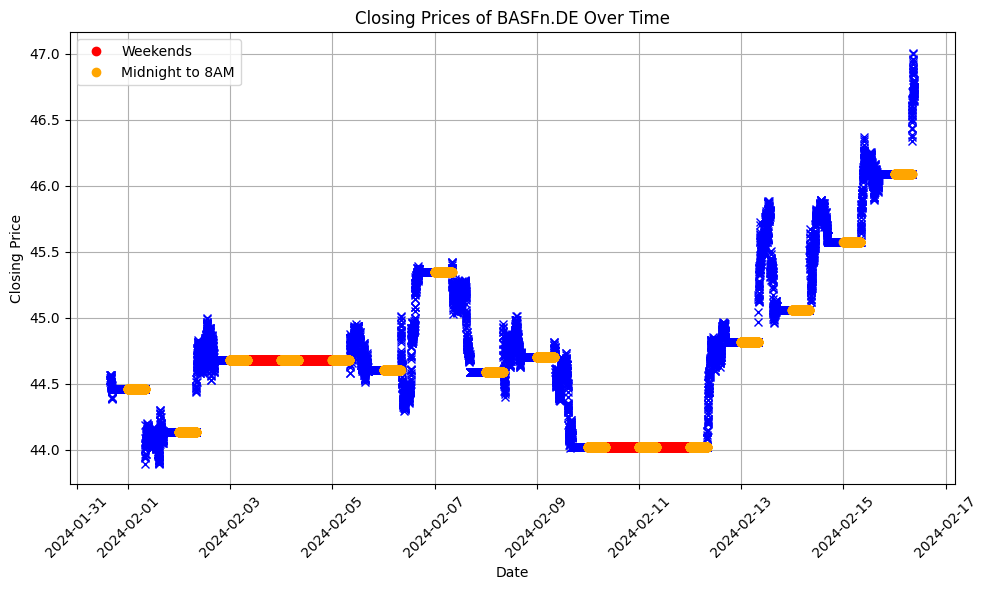

In [14]:
basf_rows = filled_data.loc['BASFn.DE']

# Plot the closing prices without connecting lines
plt.figure(figsize=(10, 6))
plt.plot(basf_rows.index.get_level_values('time'), basf_rows['CLOSE'], marker='x', linestyle='None', color='blue')  # Use linestyle='None' to not connect the points

# Plot weekends
weekend_indices = basf_rows.index.get_level_values('time').weekday >= 5  # Weekday values greater than or equal to 5 are weekends
plt.plot(basf_rows.index.get_level_values('time')[weekend_indices], basf_rows['CLOSE'][weekend_indices], marker='o', linestyle='None', color='red', label='Weekends')

# Plot times between midnight and 8 o'clock
midnight_to_8_indices = (basf_rows.index.get_level_values('time').hour < 8)  # Times where hour is less than 8
plt.plot(basf_rows.index.get_level_values('time')[midnight_to_8_indices], basf_rows['CLOSE'][midnight_to_8_indices], marker='o', linestyle='None', color='orange', label='Midnight to 8AM')

plt.title('Closing Prices of BASFn.DE Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Calculate the percentage change in closing prices for different time intervals (2, 5, 10, and 30 minutes) after a specific timestamp for each stock ticker. It updates the raw_data_df_new DataFrame with these calculated percentage changes, handling any missing data.

In [16]:
intervals = [2, 5, 10]
raw_data_df_new['2-Minutes_real'] = None
raw_data_df_new['5-Minutes_real'] = None
raw_data_df_new['10-Minutes_real'] = None
raw_data_df_new['versionCreatedClose'] = None

# Iterate through the rows of raw_data_df_new
for idx, newsDate in enumerate(raw_data_df_new['versionCreated'].values):
    sTime_str = str(raw_data_df_new['versionCreated'][idx])
    sTime_dt = datetime.datetime.strptime(sTime_str, '%Y-%m-%d %H:%M:%S')

    # Set seconds component to 00
    sTime_dt = sTime_dt.replace(second=0)

    # Format datetime object without seconds
    sTime_without_seconds = sTime_dt.strftime('%Y-%m-%d %H:%M:%S')

    # Get the ticker value
    ticker = raw_data_df_new['tickers'].iloc[idx]

    try:
        # Get the close price at versionCreated time
        version_close_price = filled_data.loc[(ticker, sTime_without_seconds)].CLOSE
        raw_data_df_new.loc[idx, 'versionCreatedClose'] = version_close_price

        # Iterate through the time intervals
        for interval in intervals:
            # Calculate the target time for the interval
            target_time = sTime_dt + datetime.timedelta(minutes=interval)

            try:
                # Get the closing price at the target time
                target_price = filled_data.loc[(ticker, target_time)].CLOSE

                # Calculate the delta
                delta = ((target_price / version_close_price) - 1) * 100
                print(delta)

                # Update the corresponding column in raw_data_df_new
                column_name = f"{interval}-Minutes"
                raw_data_df_new.loc[idx, column_name] = delta

                # Update the real price columns
                real_price_column_name = f"{interval}-Minutes_real"
                raw_data_df_new.loc[idx, real_price_column_name] = target_price
            except KeyError:
                print(f"ERROR: Data not available for {ticker} at {target_time}")
                # Handle missing data for the target time
                pass

    except KeyError:
        print(f"ERROR: Data not available for {ticker} at {sTime_without_seconds}")
        # Handle missing data for versionCreated time
        pass

columns_to_check = ['2-Minutes', '5-Minutes', '10-Minutes']

# Filter rows where all specified columns are either 0 or 0.00
filtered_df = raw_data_df_new[(raw_data_df_new[columns_to_check] == 0).all(axis=1)]

# Drop the filtered rows from the original DataFrame
data_df = raw_data_df_new.drop(filtered_df.index)
data_df.reset_index(drop=True, inplace=True)
data_df.dropna(inplace=True)
data_df

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.05934718100890635
0.18991097922849143
0.14243323442137967
0.011943150603133112
0.04777260241253245
-0.08360205422189848
-0.08361204013378476
-0.07166746297181392
-0.059722885809843085
-0.035923841456120265
-0.035923841456120265
0.05987306909351897
-0.07183048006702553
-0.07183048006702553
-0.04788698671135405
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.04797313504438794
-0.11993283761093654
-0.2158791076996791
0.02414875633904856
0.0603

,versionCreated,text,storyId,tickers,2-Minutes_real,5-Minutes_real,10-Minutes_real,versionCreatedClose,2-Minutes,5-Minutes,10-Minutes
0,2024-02-14 15:23:35,Britain sees launch of Lilly's weight-loss dru...,urn:newsml:newswire.refinitiv.com:20240214:nL2...,NOVOb.CO,843.0,844.1,843.7,842.5,0.059347,0.189911,0.142433
1,2024-02-14 14:06:31,Novo Nordisk A/S (NYSE:NVO) Shares Bought by M...,urn:newsml:newsroom.refinitiv.com:20240214:nNR...,NOVOb.CO,837.4,837.7,836.6,837.3,0.011943,0.047773,-0.083602
2,2024-02-14 13:07:18,NOVO NORDISK A S -- 6-K,urn:newsml:newswire.refinitiv.com:20240214:nEO...,NOVOb.CO,836.5,836.6,836.7,837.2,-0.083612,-0.071667,-0.059723
3,2024-02-14 12:03:04,Novo Nordisk A/S - Novo Nordisk A/S: Trading i...,urn:newsml:newswire.refinitiv.com:20240214:nND...,NOVOb.CO,834.8,834.8,835.6,835.1,-0.035924,-0.035924,0.059873
4,2024-02-14 11:59:37,REG-Novo Nordisk A/S: Trading in Novo Nordisk ...,urn:newsml:newswire.refinitiv.com:20240214:nGN...,NOVOb.CO,834.7,834.7,834.9,835.3,-0.071830,-0.071830,-0.047887
...,...,...,...,...,...,...,...,...,...,...,...
11608,2024-02-01 11:34:51,REG - Reckitt Benckiser Gp - Total Voting Rights,urn:newsml:newsroom.refinitiv.com:20240201:nRS...,RKT.L,5708.0,5712.0,5708.824,5712.0,-0.070028,0.000000,-0.055602
11609,2024-02-01 10:59:26,REG - Reckitt Benckiser Gp - Total Voting Rights,urn:newsml:newswire.refinitiv.com:20240201:nRS...,RKT.L,5696.0,5701.7285,5696.0,5698.0,-0.035100,0.065435,-0.035100
11610,2024-02-01 10:07:15,Thursday's Preview: Can Reckitt Benckiser rebo...,urn:newsml:newsroom.refinitiv.com:20240201:nNR...,RKT.L,5694.0,5694.0,5690.0,5694.0,0.000000,0.000000,-0.070249
11611,2024-02-01 09:12:13,Beacon Pharmaceuticals's Earnings Growth Outpe...,urn:newsml:newsroom.refinitiv.com:20240201:nNR...,RKT.L,5716.0,5712.0,5704.0,5714.0,0.035002,-0.035002,-0.175009


##### Conduct statistical exploration

Performing a comprehensive analysis of price changes over different time intervals (2, 5, 10, and 30 minutes). Starting by calculating the mean and standard deviation for each interval, followed by performing one-sample t-tests to determine if the mean price change is significantly different from zero. The results, including t-statistics and p-values, are summarized in a DataFrame, which also indicates whether the results are statistically significant (p-value > 0.01). Defines a function to perform F-tests, which compare the variances of price changes between different time intervals. It calculates the variances and sample sizes for each interval and performs pairwise F-tests. The results, including F-statistics and p-values, are summarized in a DataFrame to compare the variances between intervals.

In [17]:
mean_values = data_df[['2-Minutes', '5-Minutes', '10-Minutes']].mean()
std_values = data_df[['2-Minutes', '5-Minutes', '10-Minutes']].std()

# Perform one-sample t-test for each time interval
t_test_results = {}
for column in ['2-Minutes', '5-Minutes', '10-Minutes']:
    t_stat, p_value = ttest_1samp(data_df[column], 0)
    t_test_results[column] = {'t-statistic': t_stat, 'p-value': p_value}

# Create a summary dataframe to display results
summary_df = pd.DataFrame({
    'Mean': mean_values,
    'Standard Deviation': std_values,
    't-statistic': [t_test_results[col]['t-statistic'] for col in ['2-Minutes', '5-Minutes', '10-Minutes']],
    'p-value': [t_test_results[col]['p-value'] for col in ['2-Minutes', '5-Minutes', '10-Minutes']]
})

# Add a column to show significance (True if p-value > 0.01, indicating not significantly different from zero)
summary_df['Significant (p > 0.01)'] = summary_df['p-value'] > 0.01

# Display the summary dataframe
print(summary_df)

def f_test(var1, var2, n1, n2):
    f_stat = var1 / var2
    dfn = n1 - 1  # degrees of freedom for the numerator
    dfd = n2 - 1  # degrees of freedom for the denominator
    p_value = 1 - f.cdf(f_stat, dfn, dfd)
    return f_stat, p_value

# Calculate variances and sample sizes
variances = data_df[['2-Minutes', '5-Minutes', '10-Minutes']].var()
sample_sizes = data_df[['2-Minutes', '5-Minutes', '10-Minutes']].count()

# Perform F-tests pairwise
f_test_results = {}
intervals = ['2-Minutes', '5-Minutes', '10-Minutes']
for i in range(len(intervals) - 1):
    for j in range(i + 1, len(intervals)):
        interval1 = intervals[i]
        interval2 = intervals[j]
        f_stat, p_value = f_test(variances[interval1], variances[interval2], sample_sizes[interval1], sample_sizes[interval2])
        f_test_results[f'{interval1} vs {interval2}'] = {'f-statistic': f_stat, 'p-value': p_value}

# Display the standard deviations and F-test results
summary_df = pd.DataFrame({
    'Standard Deviation': std_values,
    'Variance': variances,
    'Sample Size': sample_sizes
})

f_test_df = pd.DataFrame(f_test_results).T

print("Summary of Standard Deviations, Variances, and Sample Sizes:")
print(summary_df)
print("\nF-Test Results (Comparing Variances):")
print(f_test_df)

                Mean  Standard Deviation  t-statistic   p-value  \
2-Minutes   0.009603            0.946411     1.093503  0.274196   
5-Minutes   0.021026            1.197575     1.892041  0.058510   
10-Minutes  0.004632            1.084224     0.460420  0.645224   

            Significant (p > 0.01)  
2-Minutes                     True  
5-Minutes                     True  
10-Minutes                    True  
Summary of Standard Deviations, Variances, and Sample Sizes:
            Standard Deviation  Variance  Sample Size
2-Minutes             0.946411  0.895693        11613
5-Minutes             1.197575  1.434186        11613
10-Minutes            1.084224  1.175542        11613

F-Test Results (Comparing Variances):
                         f-statistic       p-value
2-Minutes vs 5-Minutes      0.624531  1.000000e+00
2-Minutes vs 10-Minutes     0.761941  1.000000e+00
5-Minutes vs 10-Minutes     1.220021  1.110223e-16


Calculating other statistical measures such as median, minimum, maximum, quartiles, skewness, and kurtosis for each time interval. It creates a summary DataFrame and visualizes the results in a table plot, highlighting the lower and upper quartiles.

                Mean  Standard Deviation    Minimum    Maximum  \
2-Minutes   0.009603            0.946411 -55.860465  27.270408   
5-Minutes   0.021026            1.197575 -61.102326  27.270408   
10-Minutes  0.004632            1.084224 -61.102326  27.270408   

            25th Percentile  75th Percentile  Skewness     Kurtosis       IQR  
2-Minutes         -0.047416         0.030239 -1.198481  1524.148266  0.077655  
5-Minutes         -0.068182         0.047596  0.925649   865.981979  0.115778  
10-Minutes        -0.115393         0.074239 -2.850599  1193.454780  0.189633  


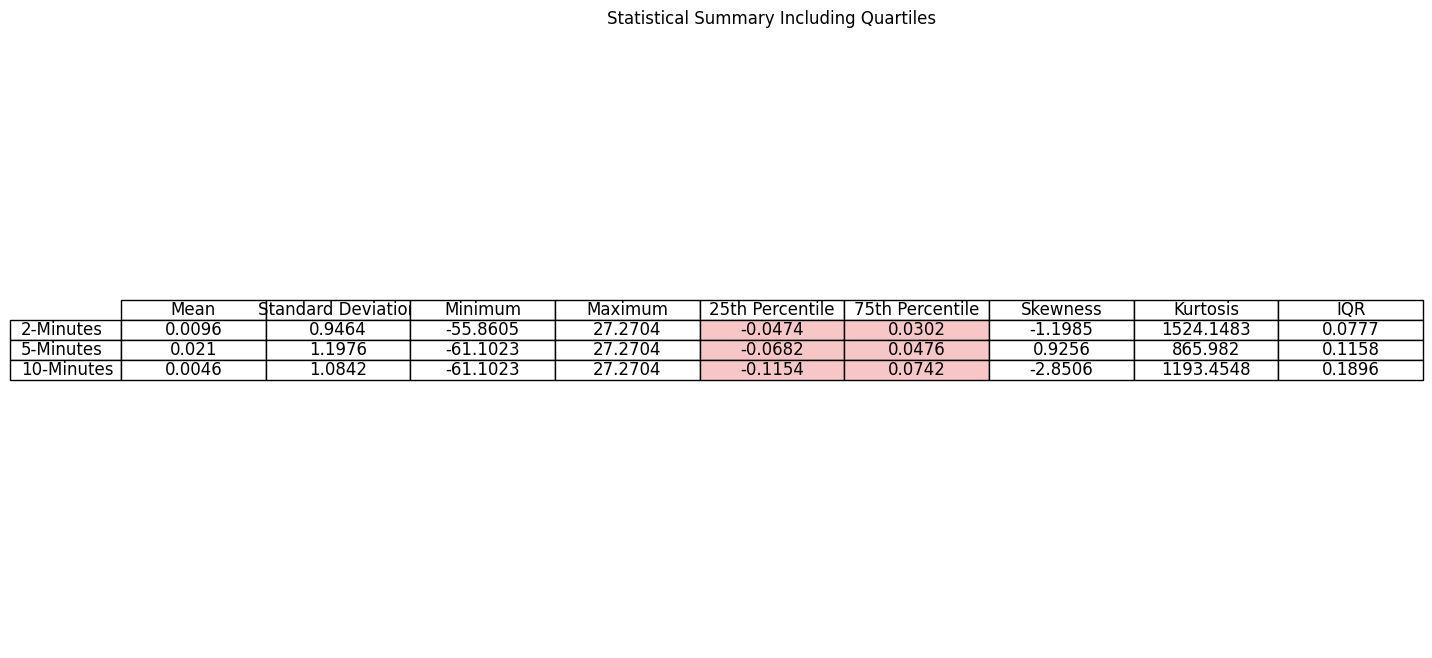

LeveneResult(statistic=0.0, pvalue=1.0)

In [18]:
statistics = {
    'Mean': data_df[['2-Minutes', '5-Minutes', '10-Minutes']].mean(),
    'Standard Deviation': data_df[['2-Minutes', '5-Minutes', '10-Minutes']].std(),
    'Minimum': data_df[['2-Minutes', '5-Minutes', '10-Minutes']].min(),
    'Maximum': data_df[['2-Minutes', '5-Minutes', '10-Minutes']].max(),
    '25th Percentile': data_df[['2-Minutes', '5-Minutes', '10-Minutes']].quantile(0.25),
    '75th Percentile': data_df[['2-Minutes', '5-Minutes', '10-Minutes']].quantile(0.75),
    'Skewness': data_df[['2-Minutes', '5-Minutes', '10-Minutes']].skew(),
    'Kurtosis': data_df[['2-Minutes', '5-Minutes', '10-Minutes']].kurtosis()
}

# Calculate Interquartile Range (IQR)
statistics['IQR'] = statistics['75th Percentile'] - statistics['25th Percentile']

# Create a summary dataframe
summary_df = pd.DataFrame(statistics)
print(summary_df)

# Set up the matplotlib figure
plt.figure(figsize=(14, 8))

# Remove the axis
ax = plt.gca()
ax.axis('off')

# Create a table plot
table = plt.table(cellText=summary_df.round(4).values, 
                  colLabels=summary_df.columns, 
                  rowLabels=summary_df.index, 
                  cellLoc='center', 
                  loc='center')

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)

# Highlight the lower and upper quartiles
for i in range(len(summary_df)):
    for j in range(len(summary_df.columns)):
        if summary_df.columns[j] in ['25th Percentile', '75th Percentile']:
            table[(i+1, j)].set_facecolor('#f7c7c7')  # Highlighting quartiles with a color

# Display the table
plt.title('Statistical Summary Including Quartiles')
plt.show()

levene(data_df["2-Minutes"], data_df["2-Minutes"])


Generating a boxplot to visualize the distribution of price changes over different time intervals and plots the standard deviations of price changes for each interval in a bar chart.

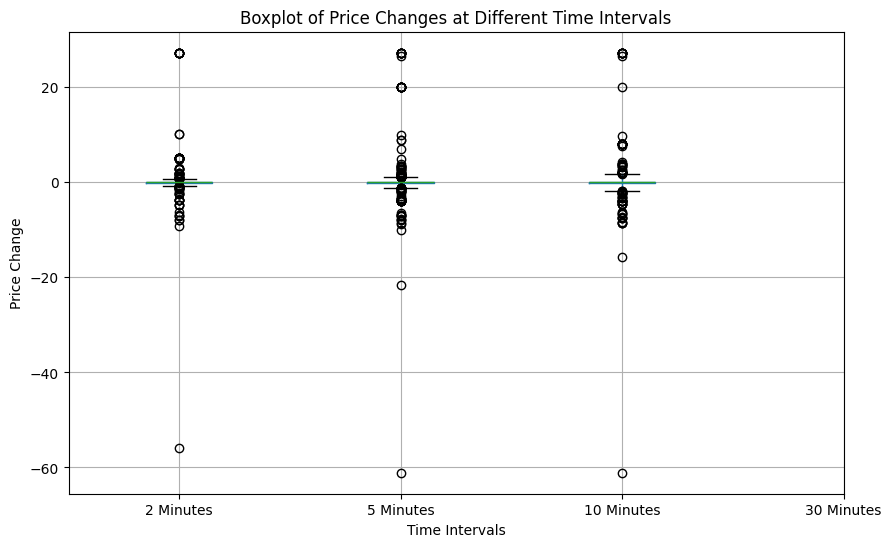

In [19]:

plt.figure(figsize=(10, 6))
data_df[['2-Minutes', '5-Minutes', '10-Minutes']].boxplot(whis=9)  
plt.title('Boxplot of Price Changes at Different Time Intervals')
plt.ylabel('Price Change')
plt.xlabel('Time Intervals')
plt.xticks(ticks=[1, 2, 3, 4], labels=['2 Minutes', '5 Minutes', '10 Minutes', '30 Minutes'])
plt.grid(True)

# Save the plot as an image or display it
plt.savefig('boxplot.png')
plt.show()

2-Minutes     0.946411
5-Minutes     1.197575
10-Minutes    1.084224
dtype: float64
F-test Results (Variance Comparison):
('2-Minutes', '5-Minutes'): F-statistic = 0.6503587593273972, p-value = 0.41999270084850493
('5-Minutes', '10-Minutes'): F-statistic = 1.195947668259668, p-value = 0.2741444584947324


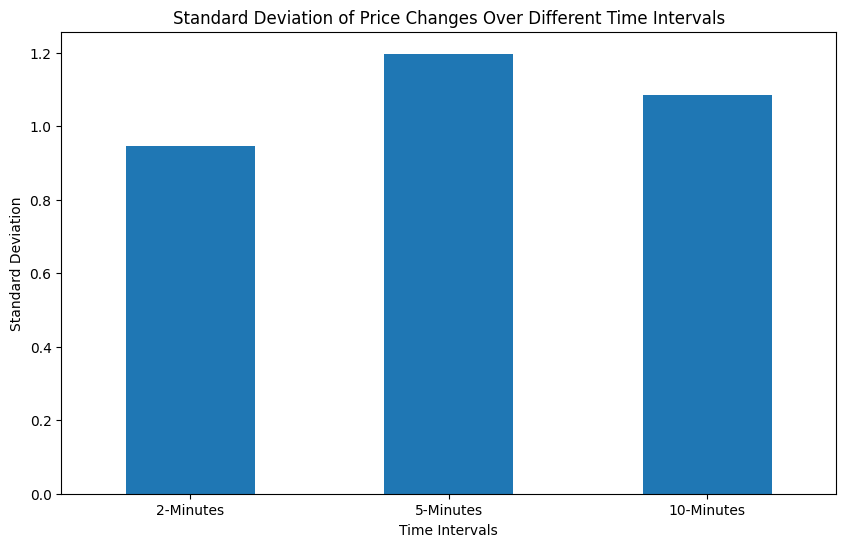

In [21]:
std_devs = data_df[['2-Minutes', '5-Minutes', '10-Minutes']].std()
print(std_devs)
# Perform F-test for each pair of intervals
f_test_results = {}
pairs = [('2-Minutes', '5-Minutes'), ('5-Minutes', '10-Minutes')]

for pair in pairs:
    f_stat, p_value = f_oneway(data_df[pair[0]].dropna(), data_df[pair[1]].dropna())
    f_test_results[pair] = (f_stat, p_value)

# Display the F-test results
print("F-test Results (Variance Comparison):")
for pair, (f_stat, p_value) in f_test_results.items():
    print(f"{pair}: F-statistic = {f_stat}, p-value = {p_value}")

# Plot the standard deviations
plt.figure(figsize=(10, 6))
std_devs.plot(kind='bar')
plt.title('Standard Deviation of Price Changes Over Different Time Intervals')
plt.xlabel('Time Intervals')
plt.ylabel('Standard Deviation')
plt.xticks(rotation=0)
plt.show()

##### Conduct visual exploration

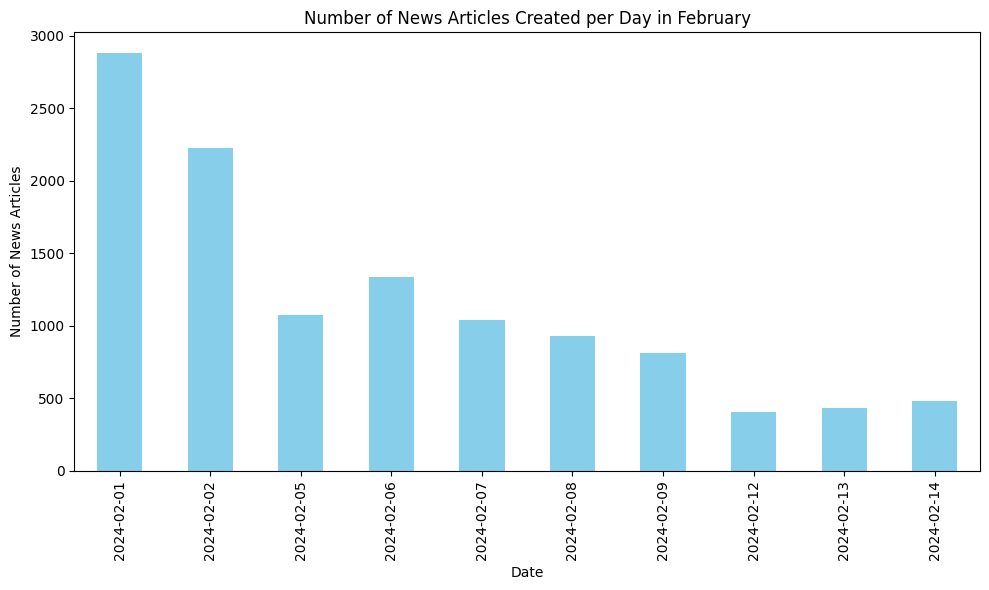

In [22]:
data_df['versionCreated'] = pd.to_datetime(data_df['versionCreated'])

month_data = data_df[data_df['versionCreated'].dt.month == 2]

news_per_day = month_data.groupby(month_data['versionCreated'].dt.date).size()

plt.figure(figsize=(10, 6))
news_per_day.plot(kind='bar', color='skyblue')
plt.title(f'Number of News Articles Created per Day in {date_to.strftime("%B")}')
plt.xlabel('Date')
plt.ylabel('Number of News Articles')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

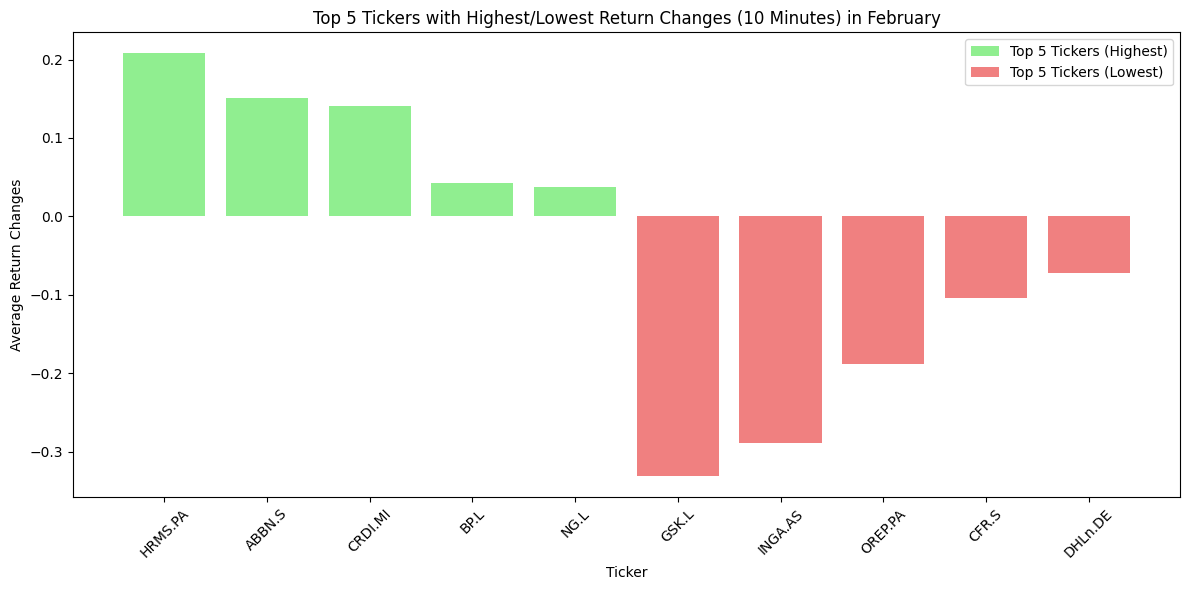

In [23]:
return_columns = ['2-Minutes', '5-Minutes', '10-Minutes']
average_return_by_ticker = data_df.groupby('tickers')[return_columns].mean()

top_n = 5
top_n_tickers_high = average_return_by_ticker['10-Minutes'].nlargest(top_n)

top_n_tickers_low = average_return_by_ticker['10-Minutes'].nsmallest(top_n)

plt.figure(figsize=(12, 6))
plt.bar(top_n_tickers_high.index, top_n_tickers_high, color='lightgreen', label='Top 5 Tickers (Highest)')
plt.bar(top_n_tickers_low.index, top_n_tickers_low, color='lightcoral', label='Top 5 Tickers (Lowest)')
plt.title(f'Top 5 Tickers with Highest/Lowest Return Changes (10 Minutes) in {date_to.strftime("%B")}')
plt.xlabel('Ticker')
plt.ylabel('Average Return Changes')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

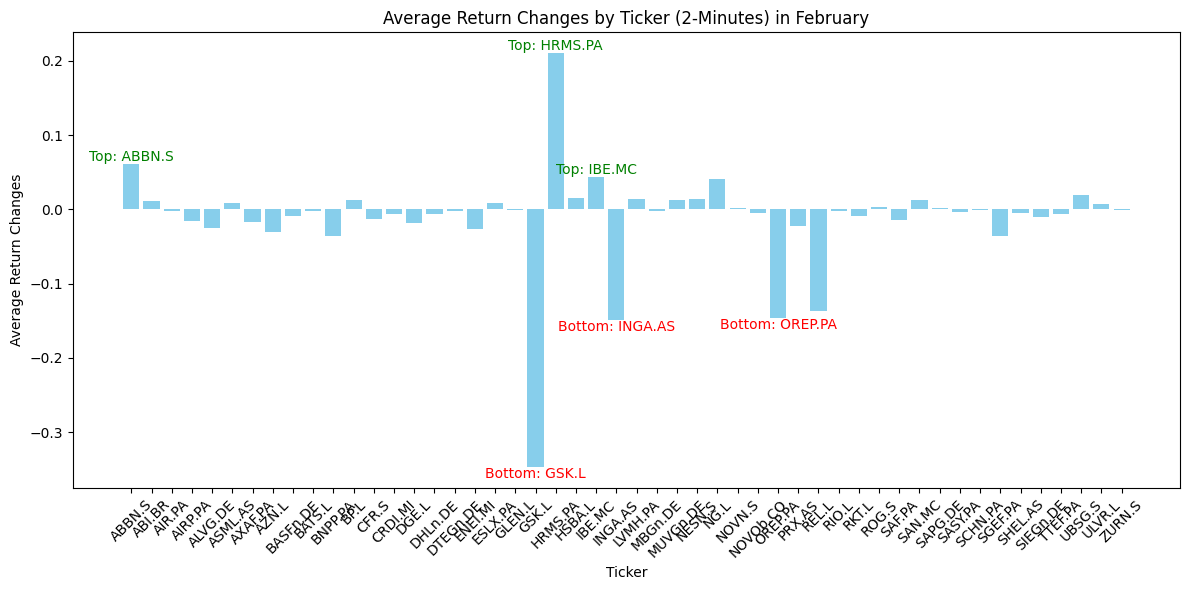

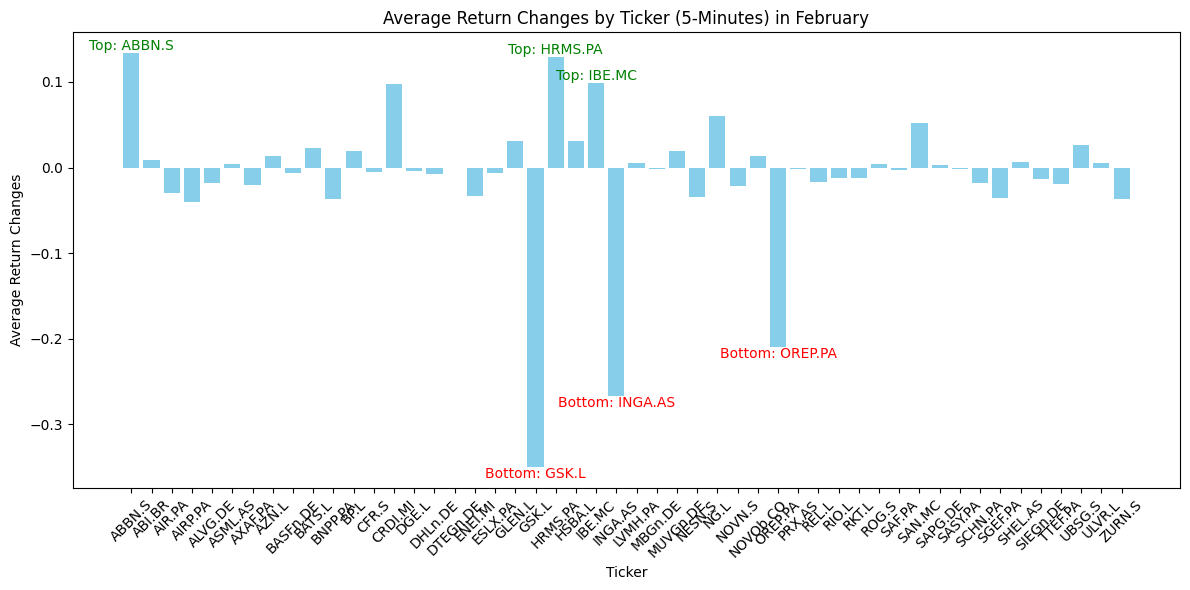

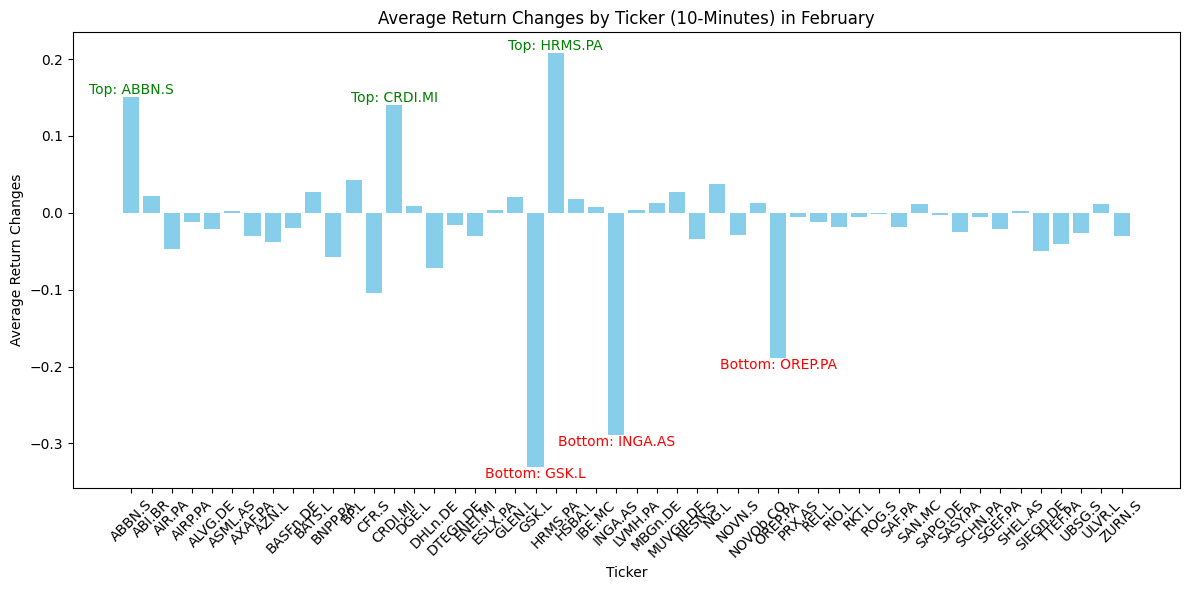

In [24]:
for column in return_columns:
    average_return_by_ticker = data_df.groupby('tickers')[column].mean()

    top_performers = average_return_by_ticker.nlargest(3)
    bottom_performers = average_return_by_ticker.nsmallest(3)

    plt.figure(figsize=(12, 6))
    plt.bar(average_return_by_ticker.index, average_return_by_ticker, color='skyblue')
    plt.title(f'Average Return Changes by Ticker ({column}) in {date_to.strftime("%B")}')
    plt.xlabel('Ticker')
    plt.ylabel('Average Return Changes')
    plt.xticks(rotation=45)
    plt.tight_layout()
    for ticker, avg_return in top_performers.items():
        plt.text(ticker, avg_return, f'Top: {ticker}', ha='center', va='bottom', color='green')

    for ticker, avg_return in bottom_performers.items():
        plt.text(ticker, avg_return, f'Bottom: {ticker}', ha='center', va='top', color='red')

    plt.show()


In [25]:
all_titles = ' '.join(data_df['text'])

tokens = word_tokenize(all_titles)
pos_tags = pos_tag(tokens)

lemmatizer = WordNetLemmatizer()

verbs = [word for word, tag in pos_tags if tag.startswith('VB') and word.lower() not in stopwords.words('english') and word.islower()]
lemmatized_verbs = [lemmatizer.lemmatize(verb, pos='v') for verb in verbs]

merged_counts = {}

# Merge counts of similar verbs
for verb in lemmatized_verbs:
    # Lemmatize the verb
    verb_lemma = lemmatizer.lemmatize(verb, pos='v')
    
    # Merge 'compare' and 'continue' into 'compare'
    if verb_lemma in ['compare', 'continue']:
        merged_counts['compare'] = merged_counts.get('compare', 0) + 1
    else:
        merged_counts[verb_lemma] = merged_counts.get(verb_lemma, 0) + 1

# Get the top 50 most used verbs
top_verbs = sorted(merged_counts.items(), key=lambda x: x[1], reverse=True)[:50]

# Print the top 50 most used verbs
for verb, count in top_verbs:
    print(verb, count)

compare 1058
offer 206
issue 137
concern 117
underperform 106
outperform 100
drop 92
increase 77
decrease 75
trade 73
hit 73
see 70
look 60
buy 55
rise 51
lift 49
fall 45
say 40
move 37
strengthen 28
rebound 23
keep 21
sell 21
make 20
show 20
beat 20
's 18
cover 16
climb 15
avg 15
post 14
add 14
slide 14
boost 13
announce 13
end 13
lead 13
plc 13
set 13
win 12
expect 12
overblown 11
join 11
pay 11
lose 11
take 10
acquire 10
forecast 10
accelerate 10
report 9


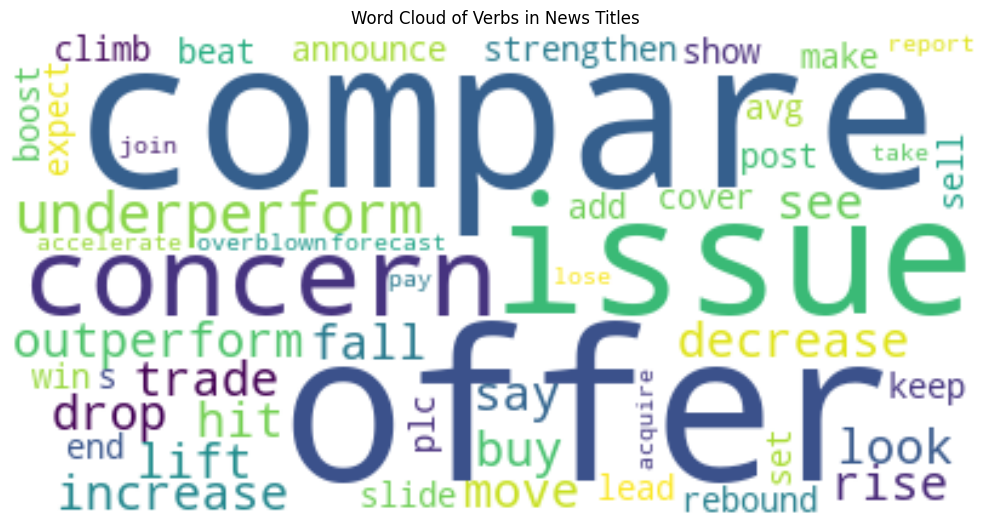

In [26]:
verbs_text = ' '.join([verb for verb, _ in top_verbs])
wordcloud = WordCloud(background_color='white').generate(verbs_text)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Verbs in News Titles')
plt.axis('off')
plt.tight_layout()
plt.show()

### EXTRACT NEWS

Define helper functions that makes the data extraction easier - Extraction done according to HTML stripping.


In [27]:
headers = { 
    'User-Agent'      : 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/71.0.3578.98 Safari/537.36', 
    'Accept'          : 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8', 
    'Accept-Language' : 'en-US,en;q=0.5',
    'DNT'             : '1',  
    'Connection'      : 'close'
    }

def get_excerpts(raw_text, company_name, excerpt_length=500):
    """
    Divide the text in smaller chuncks of length 500 (makes it easier for the algorithm to process)
    """
    excerpts = []
    start_index = 0
    while start_index != -1:
        start_index = raw_text.find(company_name, start_index)
        if start_index != -1:
            end_index = min(len(raw_text), start_index + excerpt_length)
            excerpt = raw_text[start_index:end_index]
            excerpts.append(excerpt)
            start_index += 1
    return excerpts

def extract_main_content(soup):
    """
    Strip down HTML Code into readable Strings
    """
    content_divs = soup.find_all("div", class_=lambda c: c and "content" in c.lower())
    
    text = " ".join(div.get_text(separator=" ") for div in content_divs)
    
    text = re.sub(r'\n+', '\n', text)  
    text = re.sub(r'\s+', ' ', text)   
    
    return text.strip()  



In [28]:
condition = (data_df['2-Minutes'] == data_df['5-Minutes']) & \
            (data_df['2-Minutes'] == data_df['10-Minutes'])
data_df[condition]

,versionCreated,text,storyId,tickers,2-Minutes_real,5-Minutes_real,10-Minutes_real,versionCreatedClose,2-Minutes,5-Minutes,10-Minutes
199,2024-02-02 10:54:07,Novo Nordisk A/S (NYSE:NVO) PT Raised to $140.00,urn:newsml:newsroom.refinitiv.com:20240202:nNR...,NOVOb.CO,786.2,786.2,786.2,785.9,0.038173,0.038173,0.038173
552,2024-02-02 10:52:15,Nestle (NESN: CHF99.04) offers dividend yield ...,urn:newsml:newsroom.refinitiv.com:20240202:nNR...,NESN.S,99.01,99.01,99.01,99.03,-0.020196,-0.020196,-0.020196
585,2024-02-01 06:56:58,Can Nestle rebound after recent dip?,urn:newsml:newsroom.refinitiv.com:20240201:nNR...,NESN.S,99.0,99.0,99.0,98.59,0.415864,0.415864,0.415864
612,2024-02-07 15:32:14,Hermes International S.C.A ADR (HESAY: $219.44...,urn:newsml:newsroom.refinitiv.com:20240207:nNR...,HRMS.PA,2037.5,2037.5,2037.5,2036.5,0.049104,0.049104,0.049104
635,2024-02-05 15:52:14,How Hermes International S.C.A's dividend comp...,urn:newsml:newsroom.refinitiv.com:20240205:nNR...,HRMS.PA,2030.0,2030.0,2030.0,2031.5,-0.073837,-0.073837,-0.073837
...,...,...,...,...,...,...,...,...,...,...,...
11513,2024-02-07 15:11:42,Renata's Earnings Growth Outperforms Reckitt B...,urn:newsml:newsroom.refinitiv.com:20240207:nNR...,RKT.L,5796.0,5796.0,5796.0,5792.0,0.069061,0.069061,0.069061
11514,2024-02-07 15:11:42,Beximco Pharmaceuticals's Earnings Growth Outp...,urn:newsml:newsroom.refinitiv.com:20240207:nNR...,RKT.L,5796.0,5796.0,5796.0,5792.0,0.069061,0.069061,0.069061
11518,2024-02-07 13:57:01,Wednesday's Preview: Can Reckitt Benckiser con...,urn:newsml:newsroom.refinitiv.com:20240207:nNR...,RKT.L,5800.0,5800.0,5800.0,5802.0,-0.034471,-0.034471,-0.034471
11545,2024-02-06 12:12:07,Investors look to see if Reckitt Benckiser's r...,urn:newsml:newsroom.refinitiv.com:20240206:nNR...,RKT.L,5760.0,5760.0,5760.0,5760.641,-0.011127,-0.011127,-0.011127


WARNING THIS CODE TAKES A WHILE TO RUN!


The goal of this part is to iterate through a DataFrame (data_df) and retrieve news stories based on their storyId. For each row, it fetches the HTML content of the news story, extracts the main content, and updates the storyId column with this extracted text. Also handles errors by appending the row index to a list (rows_to_drop) and saves intermediate results to a CSV file periodically. This ensures that any server errors or other issues are logged and managed appropriately.

In [32]:

test_df = copy.deepcopy(data_df)
rows_to_drop = []  # this is more like rows with errors /sometimes we get server error or something similar




for myid, row in tqdm(data_df.iterrows(), total=len(data_df)):
    try:
        if myid <= -1:
            continue
        else:
            html_test = ek.get_news_story(row['storyId'])

            soup = BeautifulSoup(html_test, 'html.parser')
            text_raw = extract_main_content(soup)   
            print(f'{myid}_{text_raw}')
            test_df['storyId'][myid] = text_raw
            display(test_df[myid-1:myid+1])

            if myid % 50 ==1:
                test_df.to_csv("first_half_temp_6.csv")
                with open(r'C:\Users\Boyu Wu\Documents\RWTH_Work\MA-Test\rows_to_drop_temp.txt', 'w') as fp:
                    for item in rows_to_drop:
                        # write each item on a new line
                        fp.write("%s\n" % item)
    except EikonError as e:
        print(f'EikonError: {e}')
        rows_to_drop.append(myid)
    except Exception as e:
        print(f'{myid}_{e}')
        rows_to_drop.append(myid)
        

        error_values_df = copy.deepcopy(test_df)
        error_values_drop = copy.deepcopy(rows_to_drop)
        break

  0%|          | 0/11613 [00:00<?, ?it/s]

0_By Ludwig Burger FRANKFURT, Feb 14 (Reuters) - Eli Lilly's LLY.N Mounjaro drug is being launched in Britain this week, two pharmacy companies said on Wednesday, making the UK the fourth European country to introduce the highly-anticipated obesity drug. British pharmacy and beauty chain Superdrug said on Wednesday that eligible private patients could seek prescriptions for Mounjaro, also approved for diabetes, through its Online Doctor service from Thursday. The retail chain added, however, it would prioritise its stock of Mounjaro for National Health Service patients, citing likely strong demand as indicated by the popularity of Novo Nordisk's rival weight-loss drug Wegovy , which was introduced in the UK last year. Britain's Simple Online Pharmacy told Reuters it started filling Mounjaro prescriptions and sending out packs on Tuesday. "All pharmacies in the UK are able to order Mounjaro which is then available to both NHS and private patients," a spokesperson at Simple said. Lilly d

,versionCreated,text,storyId,tickers,2-Minutes_real,5-Minutes_real,10-Minutes_real,versionCreatedClose,2-Minutes,5-Minutes,10-Minutes


1_Feb 14, 2024 Montag A & Associates Inc. lifted its stake in shares of Novo Nordisk A/S (NYSE:NVO - Free Report) by 100.0% during the 3rd quarter, according to the company in its most recent 13F filing with the Securities and Exchange Commission (SEC). The firm owned 9,396 shares of the company's stock after acquiring an additional 4,698 shares during the period. Montag A & Associates Inc.'s holdings in Novo Nordisk A/S were worth $854,000 as of its most recent SEC filing. Several other hedge funds have also modified their holdings of NVO. Stone House Investment Management LLC lifted its stake in shares of Novo Nordisk A/S by 55.3% in the 2nd quarter. Stone House Investment Management LLC now owns 177 shares of the company's stock valued at $29,000 after purchasing an additional 63 shares in the last quarter. Cornerstone Planning Group LLC acquired a new position in Novo Nordisk A/S during the second quarter valued at approximately $29,000. Tower Research Capital LLC TRC grew its stak

,versionCreated,text,storyId,tickers,2-Minutes_real,5-Minutes_real,10-Minutes_real,versionCreatedClose,2-Minutes,5-Minutes,10-Minutes
0,2024-02-14 15:23:35,Britain sees launch of Lilly's weight-loss dru...,"By Ludwig Burger FRANKFURT, Feb 14 (Reuters) -...",NOVOb.CO,843.0,844.1,843.7,842.5,0.059347,0.189911,0.142433
1,2024-02-14 14:06:31,Novo Nordisk A/S (NYSE:NVO) Shares Bought by M...,"Feb 14, 2024 Montag A & Associates Inc. lifted...",NOVOb.CO,837.4,837.7,836.6,837.3,0.011943,0.047773,-0.083602


2_https://filings.ica.int.thomsonreuters.com/filings.viewer/Download.asp...


,versionCreated,text,storyId,tickers,2-Minutes_real,5-Minutes_real,10-Minutes_real,versionCreatedClose,2-Minutes,5-Minutes,10-Minutes
1,2024-02-14 14:06:31,Novo Nordisk A/S (NYSE:NVO) Shares Bought by M...,"Feb 14, 2024 Montag A & Associates Inc. lifted...",NOVOb.CO,837.4,837.7,836.6,837.3,0.011943,0.047773,-0.083602
2,2024-02-14 13:07:18,NOVO NORDISK A S -- 6-K,https://filings.ica.int.thomsonreuters.com/fil...,NOVOb.CO,836.5,836.6,836.7,837.2,-0.083612,-0.071667,-0.059723


3_English Published: 2024-02-14 12:59:37 CET Novo Nordisk A/S Managers' Transactions Novo Nordisk A/S: Trading in Novo Nordisk shares by board members, executives and associated persons Bagsværd, Denmark, 14 February 2024 - This company announcement discloses the data of the transaction(s) made in Novo Nordisk shares by the company's board members, executives and their associated persons in accordance with Article 19 of Regulation No. 596/2014 on market abuse. The company's board members, executives and their associated persons have reported the transactions to Novo Nordisk and have given Novo Nordisk power of attorney on their behalf to publish trading in Novo Nordisk shares by the company's board members, executives and their associated persons. Please find below a statement of such trading in shares issued by Novo Nordisk. Details of the person discharging managerial responsibilities/person closely associated a) Name of the Board member/Executive/Associated Person Elisabeth Dahl Chr

,versionCreated,text,storyId,tickers,2-Minutes_real,5-Minutes_real,10-Minutes_real,versionCreatedClose,2-Minutes,5-Minutes,10-Minutes
2,2024-02-14 13:07:18,NOVO NORDISK A S -- 6-K,https://filings.ica.int.thomsonreuters.com/fil...,NOVOb.CO,836.5,836.6,836.7,837.2,-0.083612,-0.071667,-0.059723
3,2024-02-14 12:03:04,Novo Nordisk A/S - Novo Nordisk A/S: Trading i...,English Published: 2024-02-14 12:59:37 CET Nov...,NOVOb.CO,834.8,834.8,835.6,835.1,-0.035924,-0.035924,0.059873


4_Bagsværd, Denmark, 14 February 2024 — This company announcement discloses the data of the transaction(s) made in Novo Nordisk shares by the company’s board members, executives and their associated persons in accordance with Article 19 of Regulation No. 596/2014 on market abuse. The company’s board members, executives and their associated persons have reported the transactions to Novo Nordisk and have given Novo Nordisk power of attorney on their behalf to publish trading in Novo Nordisk shares by the company’s board members, executives and their associated persons. Please find below a statement of such trading in shares issued by Novo Nordisk. Details of the person discharging managerial responsibilities/person closely associated a) Name of the Board member/Executive/Associated Person Elisabeth Dahl Christensen 2 Reason for the notification a) Position/status Member of the Board of Directors b) Initial notification/Amendment Initial notification 3 Details of the issuer a) Name Novo N

,versionCreated,text,storyId,tickers,2-Minutes_real,5-Minutes_real,10-Minutes_real,versionCreatedClose,2-Minutes,5-Minutes,10-Minutes
3,2024-02-14 12:03:04,Novo Nordisk A/S - Novo Nordisk A/S: Trading i...,English Published: 2024-02-14 12:59:37 CET Nov...,NOVOb.CO,834.8,834.8,835.6,835.1,-0.035924,-0.035924,0.059873
4,2024-02-14 11:59:37,REG-Novo Nordisk A/S: Trading in Novo Nordisk ...,"Bagsværd, Denmark, 14 February 2024 — This com...",NOVOb.CO,834.7,834.7,834.9,835.3,-0.071830,-0.071830,-0.047887


5_Feb 13, 2024 Campbell & CO Investment Adviser LLC decreased its position in shares of Novo Nordisk A/S (NYSE:NVO - Free Report) by 20.7% during the 3rd quarter, according to the company in its most recent Form 13F filing with the Securities and Exchange Commission (SEC). The institutional investor owned 5,219 shares of the company's stock after selling 1,363 shares during the period. Campbell & CO Investment Adviser LLC's holdings in Novo Nordisk A/S were worth $475,000 at the end of the most recent quarter. Several other institutional investors also recently modified their holdings of NVO. Copeland Capital Management LLC increased its holdings in shares of Novo Nordisk A/S by 100.0% in the third quarter. Copeland Capital Management LLC now owns 282 shares of the company's stock valued at $26,000 after buying an additional 141 shares in the last quarter. Bell Investment Advisors Inc grew its position in Novo Nordisk A/S by 79.9% during the 3rd quarter. Bell Investment Advisors Inc no

,versionCreated,text,storyId,tickers,2-Minutes_real,5-Minutes_real,10-Minutes_real,versionCreatedClose,2-Minutes,5-Minutes,10-Minutes
4,2024-02-14 11:59:37,REG-Novo Nordisk A/S: Trading in Novo Nordisk ...,"Bagsværd, Denmark, 14 February 2024 — This com...",NOVOb.CO,834.7,834.7,834.9,835.3,-0.071830,-0.071830,-0.047887
5,2024-02-13 13:07:36,Novo Nordisk A/S (NYSE:NVO) Shares Sold by Cam...,"Feb 13, 2024 Campbell & CO Investment Adviser ...",NOVOb.CO,834.2,832.8,832.0,833.8,0.047973,-0.119933,-0.215879


6_Danish pharmaceutical company Novo Nordisk is being criticised for pushing a rising climate bill ahead of them. The company's overall climate load increased by 53 percent in 2023, which is more than their revenue growth of 31 percent, according to Finans.dk. Critics, including Bjarke Møller from the Council of Green Conversion, call it a' big problem'. Danish pharmaceutical company Novo Nordisk is being criticised for pushing a rising climate bill ahead of them. The company's overall climate load increased by 53 percent in 2023, which is more than their revenue growth of 31 percent, according to Finans.dk. Critics, including Bjarke Møller from the Council of Green Conversion, call it a 'big problem'. He believes that Novo has not adequately addressed the rising climate load, despite the company's commitment to reduce CO2 emissions regardless of growth rates. Novo's increase in climate load is mainly due to its value chain, also known as Scope 3, which covers subcontractors of everyth

,versionCreated,text,storyId,tickers,2-Minutes_real,5-Minutes_real,10-Minutes_real,versionCreatedClose,2-Minutes,5-Minutes,10-Minutes
5,2024-02-13 13:07:36,Novo Nordisk A/S (NYSE:NVO) Shares Sold by Cam...,"Feb 13, 2024 Campbell & CO Investment Adviser ...",NOVOb.CO,834.2,832.8,832.0,833.8,0.047973,-0.119933,-0.215879
6,2024-02-13 12:32:00,Denmark: Novo Nordisk criticised for 53% rise ...,Danish pharmaceutical company Novo Nordisk is ...,NOVOb.CO,828.4,828.7,830.0,828.2,0.024149,0.060372,0.217339


7_Feb 13, 2024 Campbell & CO Investment Adviser LLC reduced its stake in shares of Novo Nordisk A/S (NYSE:NVO - Free Report) by 20.7% in the 3rd quarter, according to the company in its most recent filing with the Securities & Exchange Commission. The fund owned 5,219 shares of the company's stock after selling 1,363 shares during the period. Campbell & CO Investment Adviser LLC's holdings in Novo Nordisk A/S were worth $475,000 at the end of the most recent quarter. Several other large investors have also bought and sold shares of NVO. Jennison Associates LLC raised its position in shares of Novo Nordisk A/S by 100.3% in the 3rd quarter. Jennison Associates LLC now owns 23,419,405 shares of the company's stock worth $2,129,761,000 after acquiring an additional 11,727,507 shares in the last quarter. Price T Rowe Associates Inc. MD grew its stake in shares of Novo Nordisk A/S by 1,514.6% in the 1st quarter. Price T Rowe Associates Inc. MD now owns 3,785,560 shares of the company's stock

,versionCreated,text,storyId,tickers,2-Minutes_real,5-Minutes_real,10-Minutes_real,versionCreatedClose,2-Minutes,5-Minutes,10-Minutes
6,2024-02-13 12:32:00,Denmark: Novo Nordisk criticised for 53% rise ...,Danish pharmaceutical company Novo Nordisk is ...,NOVOb.CO,828.4,828.7,830.0,828.2,0.024149,0.060372,0.217339
7,2024-02-13 11:46:21,"Campbell & CO Investment Adviser LLC Has $475,...","Feb 13, 2024 Campbell & CO Investment Adviser ...",NOVOb.CO,829.6,829.4,829.6,829.0,0.072376,0.048251,0.072376


8_** Brokerage Jefferies says is optimistic about U.S. drugmaker Eli Lilly's LLY.N weight-loss pill, raises price target to $853 from $814 ** Says the oral drug, known as orforglipron, is "one of the few meaningful ways" in which LLY's portfolio of obesity treatments could set it apart from Danish rival Novo Nordisk NOVOb.CO ** Launch of an oral drug could allow LLY to lower price and expand market outside of the U.S. where return on invested capital with injectable drugs is not attractive - Jefferies ** Co has recently said that orforglipron is a "bet worth taking" and it will build supply of the drug at-risk, ahead of reporting data from a late-stage trial ** 22 of 28 brokerages rate the stock "buy" or higher, remaining 6 rate it "hold" or lower; their median PT is $795, representing an upside of 7.8% to last close ** Stock has risen 26.5% YTD after gaining 59% last year (Reporting by Bhanvi Satija in Bengaluru) (( Bhanvi.Satija@thomsonreuters.com ; Outside U.S. +91 9873062788; )) (c

,versionCreated,text,storyId,tickers,2-Minutes_real,5-Minutes_real,10-Minutes_real,versionCreatedClose,2-Minutes,5-Minutes,10-Minutes
7,2024-02-13 11:46:21,"Campbell & CO Investment Adviser LLC Has $475,...","Feb 13, 2024 Campbell & CO Investment Adviser ...",NOVOb.CO,829.6,829.4,829.6,829.0,0.072376,0.048251,0.072376
8,2024-02-13 10:27:56,BUZZ-Jefferies bullish on Lilly's weight-loss ...,** Brokerage Jefferies says is optimistic abou...,NOVOb.CO,837.7,837.7,837.9,838.0,-0.035800,-0.035800,-0.011933


9_Feb 13, 2024 Novo Nordisk A- (NOVO.B.CO) traded up 0.46 % during a 24 hours period ending at 09:47 AM Central Europe on Tuesday 13th. One Novo Nordisk A- stock can currently be bought for about DKK 112.06 on popular exchanges. Current supply of Novo Nordisk A- stocks is 3.4 bn. Novo Nordisk A- has a current market capitalization of DKK 2.4 trillions and approximately DKK 3.1 bn worth of Novo Nordisk A- was traded on exchanges in the last 24 hours. Since last month end, Novo Nordisk A- has traded 12.99 % up. Simple moving average of last 200 days is at DKK 636.3. The highest price of past 52 weeks was recorded at DKK 825.1 on 02/06/2024. 52 weeks low was at DKK 476.1 on 03/16/2023. Here is how related stocks have performed in the past 24 hours: - Zealand Pharma A- (ZEAL.CO) traded down -2.53 % and now trades at DKK 488.2. Zealand Pharma A- has a market capitalisation of DKK 20.9 bn. - Saniona (30S.F) traded down -1.58 % and now trades at EUR 2.12. Saniona has a market capitalisation o

,versionCreated,text,storyId,tickers,2-Minutes_real,5-Minutes_real,10-Minutes_real,versionCreatedClose,2-Minutes,5-Minutes,10-Minutes
8,2024-02-13 10:27:56,BUZZ-Jefferies bullish on Lilly's weight-loss ...,** Brokerage Jefferies says is optimistic abou...,NOVOb.CO,837.7,837.7,837.9,838.0,-0.0358,-0.035800,-0.011933
9,2024-02-13 09:01:00,Novo Nordisk A- is trading 0.46 percent higher...,"Feb 13, 2024 Novo Nordisk A- (NOVO.B.CO) trade...",NOVOb.CO,834.9,835.5,836.3,834.9,0.0000,0.071865,0.167685


10_Feb 12, 2024 Here at Zacks, we offer our members many different opportunities to take full advantage of the stock market, as well as how to invest in ways that lead to long-term success. The Zacks Premium service makes this easier. It features daily updates of the Zacks Rank and Zacks Industry Rank; full access to the Zacks #1 Rank List; Equity Research reports; and Premium stock screens like the Earnings ESP filter. All of these can help you quickly identify what stocks to buy, what to sell, and what are today's hottest industries. The service also includes the Focus List, which is a long-term portfolio of top stocks that boast a winning, market-beating combination of growth and momentum qualities. Breaking Down the Zacks Focus List Building an investment portfolio from scratch can be difficult, so if you could, wouldn't you take a peek at a curated list of top stocks? That's what the Zacks Focus List offers. It's a portfolio of 50 stocks that serve as a starting point for long-ter

,versionCreated,text,storyId,tickers,2-Minutes_real,5-Minutes_real,10-Minutes_real,versionCreatedClose,2-Minutes,5-Minutes,10-Minutes
9,2024-02-13 09:01:00,Novo Nordisk A- is trading 0.46 percent higher...,"Feb 13, 2024 Novo Nordisk A- (NOVO.B.CO) trade...",NOVOb.CO,834.9,835.5,836.3,834.9,0.000000,0.071865,0.167685
10,2024-02-12 15:33:30,Why Novo Nordisk (NVO) is a Top Stock for the ...,"Feb 12, 2024 Here at Zacks, we offer our membe...",NOVOb.CO,828.5,828.8,830.0,828.9,-0.048257,-0.012064,0.132706


11_Feb 12, 2024 Prudent Man Advisors LLC grew its stake in Novo Nordisk A/S (NYSE:NVO - Free Report) by 93.1% during the third quarter, according to the company in its most recent 13F filing with the SEC. The institutional investor owned 2,876 shares of the company's stock after purchasing an additional 1,387 shares during the quarter. Prudent Man Advisors LLC's holdings in Novo Nordisk A/S were worth $262,000 as of its most recent filing with the SEC. Several other large investors have also modified their holdings of the stock. ICW Investment Advisors LLC increased its stake in Novo Nordisk A/S by 0.3% during the second quarter. ICW Investment Advisors LLC now owns 21,922 shares of the company's stock valued at $3,548,000 after purchasing an additional 63 shares during the last quarter. Stone House Investment Management LLC grew its position in shares of Novo Nordisk A/S by 55.3% during the 2nd quarter. Stone House Investment Management LLC now owns 177 shares of the company's stock v

,versionCreated,text,storyId,tickers,2-Minutes_real,5-Minutes_real,10-Minutes_real,versionCreatedClose,2-Minutes,5-Minutes,10-Minutes
10,2024-02-12 15:33:30,Why Novo Nordisk (NVO) is a Top Stock for the ...,"Feb 12, 2024 Here at Zacks, we offer our membe...",NOVOb.CO,828.5,828.8,830.0,828.9,-0.048257,-0.012064,0.132706
11,2024-02-12 14:42:08,Prudent Man Advisors LLC Increases Stock Posit...,"Feb 12, 2024 Prudent Man Advisors LLC grew its...",NOVOb.CO,830.6,830.0,829.4,832.3,-0.204253,-0.276343,-0.348432


12_Feb 12, 2024 Prudent Man Advisors LLC grew its position in Novo Nordisk A/S (NYSE:NVO - Free Report) by 93.1% in the third quarter, according to its most recent Form 13F filing with the Securities and Exchange Commission. The fund owned 2,876 shares of the company's stock after acquiring an additional 1,387 shares during the period. Prudent Man Advisors LLC's holdings in Novo Nordisk A/S were worth $262,000 at the end of the most recent reporting period. Several other institutional investors and hedge funds have also modified their holdings of the business. Copeland Capital Management LLC boosted its stake in Novo Nordisk A/S by 100.0% in the third quarter. Copeland Capital Management LLC now owns 282 shares of the company's stock worth $26,000 after purchasing an additional 141 shares in the last quarter. Bell Investment Advisors Inc grew its holdings in Novo Nordisk A/S by 79.9% during the 3rd quarter. Bell Investment Advisors Inc now owns 286 shares of the company's stock worth $

,versionCreated,text,storyId,tickers,2-Minutes_real,5-Minutes_real,10-Minutes_real,versionCreatedClose,2-Minutes,5-Minutes,10-Minutes
11,2024-02-12 14:42:08,Prudent Man Advisors LLC Increases Stock Posit...,"Feb 12, 2024 Prudent Man Advisors LLC grew its...",NOVOb.CO,830.6,830.0,829.4,832.3,-0.204253,-0.276343,-0.348432
12,2024-02-12 14:41:49,"Prudent Man Advisors LLC Acquires 1,387 Shares...","Feb 12, 2024 Prudent Man Advisors LLC grew its...",NOVOb.CO,831.1,830.0,828.8,831.8,-0.084155,-0.216398,-0.360664


13_https://filings.ica.int.thomsonreuters.com/filings.viewer/Download.asp...


,versionCreated,text,storyId,tickers,2-Minutes_real,5-Minutes_real,10-Minutes_real,versionCreatedClose,2-Minutes,5-Minutes,10-Minutes
12,2024-02-12 14:41:49,"Prudent Man Advisors LLC Acquires 1,387 Shares...","Feb 12, 2024 Prudent Man Advisors LLC grew its...",NOVOb.CO,831.1,830.0,828.8,831.8,-0.084155,-0.216398,-0.360664
13,2024-02-12 14:19:38,NOVO NORDISK A S -- 6-K,https://filings.ica.int.thomsonreuters.com/fil...,NOVOb.CO,833.0,832.9,833.5,832.8,0.024015,0.012008,0.084054


14_English Published: 2024-02-12 13:13:14 CET Novo Nordisk A/S Managers' Transactions Novo Nordisk A/S: Trading in Novo Nordisk shares by board members, executives and associated persons Bagsværd, Denmark, 12 February 2024 - This company announcement discloses the data of the transaction(s) made in Novo Nordisk shares by the company's board members, executives and their associated persons in accordance with Article 19 of Regulation No. 596/2014 on market abuse. The company's board members, executives and their associated persons have reported the transactions to Novo Nordisk and have given Novo Nordisk power of attorney on their behalf to publish trading in Novo Nordisk shares by the company's board members, executives and their associated persons. Please find below a statement of such trading in shares issued by Novo Nordisk. Details of the person discharging managerial responsibilities/person closely associated a) Name of the Board member/Executive/Associated Person Ludovic Helfgott 

,versionCreated,text,storyId,tickers,2-Minutes_real,5-Minutes_real,10-Minutes_real,versionCreatedClose,2-Minutes,5-Minutes,10-Minutes
13,2024-02-12 14:19:38,NOVO NORDISK A S -- 6-K,https://filings.ica.int.thomsonreuters.com/fil...,NOVOb.CO,833.0,832.9,833.5,832.8,0.024015,0.012008,0.084054
14,2024-02-12 12:16:38,Novo Nordisk A/S - Novo Nordisk A/S: Trading i...,English Published: 2024-02-12 13:13:14 CET Nov...,NOVOb.CO,835.3,834.9,834.1,835.0,0.035928,-0.011976,-0.107784


15_Bagsværd, Denmark, 12 February 2024 — This company announcement discloses the data of the transaction(s) made in Novo Nordisk shares by the company’s board members, executives and their associated persons in accordance with Article 19 of Regulation No. 596/2014 on market abuse. The company’s board members, executives and their associated persons have reported the transactions to Novo Nordisk and have given Novo Nordisk power of attorney on their behalf to publish trading in Novo Nordisk shares by the company’s board members, executives and their associated persons. Please find below a statement of such trading in shares issued by Novo Nordisk. Details of the person discharging managerial responsibilities/person closely associated a) Name of the Board member/Executive/Associated Person Ludovic Helfgott 2 Reason for the notification a) Position/status Executive Vice President b) Initial notification/Amendment Initial notification 3 Details of the issuer a) Name Novo Nordisk A/S b) LEI

,versionCreated,text,storyId,tickers,2-Minutes_real,5-Minutes_real,10-Minutes_real,versionCreatedClose,2-Minutes,5-Minutes,10-Minutes
14,2024-02-12 12:16:38,Novo Nordisk A/S - Novo Nordisk A/S: Trading i...,English Published: 2024-02-12 13:13:14 CET Nov...,NOVOb.CO,835.3,834.9,834.1,835.0,0.035928,-0.011976,-0.107784
15,2024-02-12 12:13:14,REG-Novo Nordisk A/S: Trading in Novo Nordisk ...,"Bagsværd, Denmark, 12 February 2024 — This com...",NOVOb.CO,835.3,835.3,834.2,834.7,0.071882,0.071882,-0.059902


16_Feb 12, 2024 Novo Nordisk A- (NOVO.B.CO) traded up 0.46 % during a 24 hours period ending at 12:23 PM Central Europe on Monday 12th. One Novo Nordisk A- stock can currently be bought for about DKK 112.02 on popular exchanges. Current supply of Novo Nordisk A- stocks is 3.4 bn. Novo Nordisk A- has a current market capitalization of DKK 2.4 trillions and approximately DKK 3.1 bn worth of Novo Nordisk A- was traded on exchanges in the last 24 hours. Since last month end, Novo Nordisk A- has traded 12.99 % up. Simple moving average of last 200 days is at DKK 636.3. The highest price of past 52 weeks was recorded at DKK 825.1 on 02/06/2024. 52 weeks low was at DKK 476.1 on 03/16/2023. Here is how related stocks have performed in the past 24 hours: - Ambu A- (AMBU.B.CO) traded up 2.14 % and now trades at DKK 119.3. Current market capitalisation for Ambu A- is DKK 25 bn. Current price/earnings ratio for Ambu A- is 162.58. - Nnit A- (NNIT.CO) traded down -0.41 % and now trades at DKK 99.8. 

,versionCreated,text,storyId,tickers,2-Minutes_real,5-Minutes_real,10-Minutes_real,versionCreatedClose,2-Minutes,5-Minutes,10-Minutes
15,2024-02-12 12:13:14,REG-Novo Nordisk A/S: Trading in Novo Nordisk ...,"Bagsværd, Denmark, 12 February 2024 — This com...",NOVOb.CO,835.3,835.3,834.2,834.7,0.071882,0.071882,-0.059902
16,2024-02-12 11:51:21,On Monday 12th of February Novo Nordisk A- tra...,"Feb 12, 2024 Novo Nordisk A- (NOVO.B.CO) trade...",NOVOb.CO,833.7,834.1,833.2,833.3,0.048002,0.096004,-0.012000


17_Changes source, recasts throughout with details from Novo Holdings CEO interview Feb 12 (Reuters) - Novo Holdings, the controlling shareholder of Danish obesity drugmaker Novo Nordisk NOVOb.CO , plans to invest about $35 billion by 2030, CEO Kasim Kutay told Reuters in an interview on Monday. Novo Holdings would invest about $5 billion a year in the next five years, and that could go up to $7 billion a year by 2030, Kutay said. The company, the investment arm of the Novo Nordisk Foundation, has 77% of voting shares in Novo Nordisk that makes the blockbuster obesity drug Wegovy and diabetes treatment Ozempic. Novo Holdings also has controlling stakes in industrial enzymes maker Novonesis, formerly known as Novozymes NZYMb.CO , and manages a portfolio of 160 companies. Its portfolio comprises investments across life sciences and capital investments in equities, fixed-income assets, and real estate. Kutay said dividend payments from Novo Nordisk, boosted by the popularity of Ozempic an

,versionCreated,text,storyId,tickers,2-Minutes_real,5-Minutes_real,10-Minutes_real,versionCreatedClose,2-Minutes,5-Minutes,10-Minutes
16,2024-02-12 11:51:21,On Monday 12th of February Novo Nordisk A- tra...,"Feb 12, 2024 Novo Nordisk A- (NOVO.B.CO) trade...",NOVOb.CO,833.7,834.1,833.2,833.3,0.048002,0.096004,-0.012000
17,2024-02-12 11:41:05,UPDATE 2-Novo Nordisk's controlling shareholde...,"Changes source, recasts throughout with detail...",NOVOb.CO,835.0,834.5,833.3,835.1,-0.011975,-0.071848,-0.215543


18_Feb 12, 2024 New York State Common Retirement Fund increased its position in shares of Novo Nordisk A/S (NYSE:NVO - Free Report) by 100.0% during the 3rd quarter, according to its most recent 13F filing with the Securities and Exchange Commission (SEC). The firm owned 58,906 shares of the company's stock after purchasing an additional 29,453 shares during the period. New York State Common Retirement Fund's holdings in Novo Nordisk A/S were worth $5,357,000 at the end of the most recent reporting period. Several other institutional investors and hedge funds have also recently modified their holdings of the company. Kranot Hishtalmut Le Morim Tichoniim Havera Menahelet LTD bought a new stake in Novo Nordisk A/S during the third quarter valued at about $2,408,000. Benedict Financial Advisors Inc. raised its stake in Novo Nordisk A/S by 94.0% during the 3rd quarter. Benedict Financial Advisors Inc. now owns 44,292 shares of the company's stock valued at $4,028,000 after purchasing an ad

,versionCreated,text,storyId,tickers,2-Minutes_real,5-Minutes_real,10-Minutes_real,versionCreatedClose,2-Minutes,5-Minutes,10-Minutes
17,2024-02-12 11:41:05,UPDATE 2-Novo Nordisk's controlling shareholde...,"Changes source, recasts throughout with detail...",NOVOb.CO,835.0,834.5,833.3,835.1,-0.011975,-0.071848,-0.215543
18,2024-02-12 10:41:55,"New York State Common Retirement Fund Buys 29,...","Feb 12, 2024 New York State Common Retirement ...",NOVOb.CO,835.0,835.0,835.2,834.7,0.035941,0.035941,0.059902


19_Feb 12, 2024 Jump Financial LLC purchased a new stake in shares of Novo Nordisk A/S (NYSE:NVO - Free Report) during the 3rd quarter, according to the company in its most recent 13F filing with the SEC. The institutional investor purchased 4,261 shares of the company's stock, valued at approximately $387,000. Several other hedge funds and other institutional investors also recently bought and sold shares of the stock. Nicolet Advisory Services LLC increased its stake in Novo Nordisk A/S by 109.6% in the third quarter. Nicolet Advisory Services LLC now owns 3,163 shares of the company's stock worth $282,000 after purchasing an additional 1,654 shares during the period. Savant Capital LLC increased its stake in shares of Novo Nordisk A/S by 110.0% during the third quarter. Savant Capital LLC now owns 10,580 shares of the company's stock valued at $962,000 after buying an additional 5,543 shares during the period. Wambolt & Associates LLC increased its stake in shares of Novo Nordisk A/

,versionCreated,text,storyId,tickers,2-Minutes_real,5-Minutes_real,10-Minutes_real,versionCreatedClose,2-Minutes,5-Minutes,10-Minutes
18,2024-02-12 10:41:55,"New York State Common Retirement Fund Buys 29,...","Feb 12, 2024 New York State Common Retirement ...",NOVOb.CO,835.0,835.0,835.2,834.7,0.035941,0.035941,0.059902
19,2024-02-12 09:56:24,"Jump Financial LLC Takes $387,000 Position in ...","Feb 12, 2024 Jump Financial LLC purchased a ne...",NOVOb.CO,835.8,835.8,836.0,835.1,0.083822,0.083822,0.107772


20_By Nancy Lapid Feb 12 (Reuters) - New diabetes and weight-loss drugs may benefit patients undergoing hip replacement, without adding to complication risks, according to preliminary data released on Monday at a large meeting of orthopedic surgeons. In one study reviewing use of Ozempic - the brand name for Novo Nordisk’s semaglutide prescribed for hard-to-control diabetes – the drug was associated with 44% lower odds of developing an infection of the newly implanted joint, after other risk factors were taken into account, researchers said. Semaglutide is sold under the name Wegovy for weight-loss. Those taking Ozempic also had 32% lower odds of needing to be readmitted to the hospital, with no increase in risk for postoperative complications. For the study, doctors at a large New York City hospital reviewed data on 9,465 patients with diabetes who underwent total hip arthroplasty, including 1,653 who took Ozempic. Many of the patients also had obesity, said study leader Dr. Matthew M

,versionCreated,text,storyId,tickers,2-Minutes_real,5-Minutes_real,10-Minutes_real,versionCreatedClose,2-Minutes,5-Minutes,10-Minutes
19,2024-02-12 09:56:24,"Jump Financial LLC Takes $387,000 Position in ...","Feb 12, 2024 Jump Financial LLC purchased a ne...",NOVOb.CO,835.8,835.8,836.0,835.1,0.083822,0.083822,0.107772
20,2024-02-12 08:01:00,Weight-loss drugs tied to benefit after hip re...,By Nancy Lapid Feb 12 (Reuters) - New diabetes...,NOVOb.CO,840.5,840.3,841.7,840.5,0.000000,-0.023795,0.142772


In [30]:
test_df


,versionCreated,text,storyId,tickers,2-Minutes_real,5-Minutes_real,10-Minutes_real,versionCreatedClose,2-Minutes,5-Minutes,10-Minutes
0,2024-02-14 15:23:35,Britain sees launch of Lilly's weight-loss dru...,"By Ludwig Burger FRANKFURT, Feb 14 (Reuters) -...",NOVOb.CO,843.0,844.1,843.7,842.5,0.059347,0.189911,0.142433
1,2024-02-14 14:06:31,Novo Nordisk A/S (NYSE:NVO) Shares Bought by M...,"Feb 14, 2024 Montag A & Associates Inc. lifted...",NOVOb.CO,837.4,837.7,836.6,837.3,0.011943,0.047773,-0.083602
2,2024-02-14 13:07:18,NOVO NORDISK A S -- 6-K,https://filings.ica.int.thomsonreuters.com/fil...,NOVOb.CO,836.5,836.6,836.7,837.2,-0.083612,-0.071667,-0.059723
3,2024-02-14 12:03:04,Novo Nordisk A/S - Novo Nordisk A/S: Trading i...,English Published: 2024-02-14 12:59:37 CET Nov...,NOVOb.CO,834.8,834.8,835.6,835.1,-0.035924,-0.035924,0.059873
4,2024-02-14 11:59:37,REG-Novo Nordisk A/S: Trading in Novo Nordisk ...,"Bagsværd, Denmark, 14 February 2024 — This com...",NOVOb.CO,834.7,834.7,834.9,835.3,-0.071830,-0.071830,-0.047887
...,...,...,...,...,...,...,...,...,...,...,...
11608,2024-02-01 11:34:51,REG - Reckitt Benckiser Gp - Total Voting Rights,urn:newsml:newsroom.refinitiv.com:20240201:nRS...,RKT.L,5708.0,5712.0,5708.824,5712.0,-0.070028,0.000000,-0.055602
11609,2024-02-01 10:59:26,REG - Reckitt Benckiser Gp - Total Voting Rights,urn:newsml:newswire.refinitiv.com:20240201:nRS...,RKT.L,5696.0,5701.7285,5696.0,5698.0,-0.035100,0.065435,-0.035100
11610,2024-02-01 10:07:15,Thursday's Preview: Can Reckitt Benckiser rebo...,urn:newsml:newsroom.refinitiv.com:20240201:nNR...,RKT.L,5694.0,5694.0,5690.0,5694.0,0.000000,0.000000,-0.070249
11611,2024-02-01 09:12:13,Beacon Pharmaceuticals's Earnings Growth Outpe...,urn:newsml:newsroom.refinitiv.com:20240201:nNR...,RKT.L,5716.0,5712.0,5704.0,5714.0,0.035002,-0.035002,-0.175009


As an info if one wants to recreate the results please make sure that all the data from Jan to June is included a concatination of different dataframes is nessesary here due to Refinitiv Eikons restrictions of requests: 


```spliced_df = pd.concat([zero_df, first_df, second_df, third_df, forth_df, ...])```

```spliced_df.to_csv("df_complete.csv")```

In [31]:
### Helper functions to merge and clean the data:

"""
import glob

# Use glob to find all files matching the pattern in the current directory
all_files = glob.glob("first_3600*.csv")

# Function to extract the last row number from the filename
def extract_last_number(filename):
    # Extract the base name without extension
    base_name = filename.split(".csv")[0]
    
    # If the filename contains the pattern "-", handle normally
    if "-" in base_name:
        row_numbers = base_name.split("first_3600-")[1].split("_")[0]
        # Split by '-' and convert to int list, ignore 'end' if present
        numbers = [int(num) for num in row_numbers.split("-") if num.isdigit()]
        return numbers[-1] if numbers else 3600
    else:
        # If the filename is like "first_3600_6.csv", return 3600
        return 3600

# Sort files based on the last number in their filenames
all_files.sort(key=extract_last_number)

# Initialize an empty DataFrame
first_values_df_6_complete = pd.DataFrame()

# Previous end row
prev_end_row = 0

# Iterate through the sorted file list and concatenate only the specific rows
for filename in all_files:
    # Extract the last row number from the filename
    last_row = extract_last_number(filename)
    
    # Read the CSV file
    df = pd.read_csv(filename)
    
    # Select rows from prev_end_row to last_row
    df_selected = df.iloc[prev_end_row:last_row]
    
    # Append the selected rows to the complete DataFrame
    first_values_df_6_complete = pd.concat([first_values_df_6_complete, df_selected], ignore_index=True)
    
    # Update the prev_end_row for the next iteration
    prev_end_row = last_row

# Save the merged DataFrame to a new CSV file
first_values_df_6_complete.to_csv("first_values_df_6_complete.csv", index=False)




files = glob.glob('first_values_df_*')

# Read and merge all the files
df = pd.concat([pd.read_csv(file) for file in files], ignore_index=True)


df['versionCreated'] = pd.to_datetime(df['versionCreated'])
df.sort_values(inplace=True, by='versionCreated')
df.reset_index(inplace=True, drop=True)


df['normalized_return'] = df['10-Minutes_real'] / df['versionCreatedClose']


df.sort_values("normalized_return")
df['text_strip'] = df['text'].str.replace(r'\d+', '', regex=True)

df = df[(df['normalized_return'] > (1 - 2*df['normalized_return'].std())) & (df['normalized_return'] < (1 + 2*df['normalized_return'].std()))]#.sort_values("normalized_return")
df.sort_values('normalized_return')

def filter_consecutive_rows(df, window_size=3):
    df = df.reset_index(drop=True)
    
    df['to_drop'] = False
    
    for i in range(len(df) - window_size + 1):
        subset = df.iloc[i:i + window_size]
        
        if (subset['tickers'].nunique() == 1 and 
            subset['text_strip'].nunique() == 1 and 
            subset['normalized_return'].nunique() == 1):
            df.loc[i, 'to_drop'] = True

    df_filtered = df[~df['to_drop']]
    
    df_filtered = df_filtered.drop(columns=['to_drop'])
    
    return df_filtered
def drop_consecutive_duplicates(df, subset_columns):
    mask = df[subset_columns].ne(df[subset_columns].shift()).any(axis=1)
    
    df_filtered = df[mask]
    
    df_filtered = df_filtered[~df_filtered['text_strip'].str.startswith("REMIT, Elexon,")]
    
    df_filtered = df_filtered[df_filtered['versionCreated'] < '2024-06-28 14:50:00']
    
    return df_filtered
df = filter_consecutive_rows(df)[['versionCreated', 'text', 'tickers', '2-Minutes', '5-Minutes', '10-Minutes']]
subset_columns = ['tickers', 'text_strip']  
df = drop_consecutive_duplicates(df, subset_columns)
df.reset_index(drop=True, inplace=True)
df.to_csv('df_part_1_final.csv')
"""

'\nimport glob\n\n# Use glob to find all files matching the pattern in the current directory\nall_files = glob.glob("first_3600*.csv")\n\n# Function to extract the last row number from the filename\ndef extract_last_number(filename):\n    # Extract the base name without extension\n    base_name = filename.split(".csv")[0]\n    \n    # If the filename contains the pattern "-", handle normally\n    if "-" in base_name:\n        row_numbers = base_name.split("first_3600-")[1].split("_")[0]\n        # Split by \'-\' and convert to int list, ignore \'end\' if present\n        numbers = [int(num) for num in row_numbers.split("-") if num.isdigit()]\n        return numbers[-1] if numbers else 3600\n    else:\n        # If the filename is like "first_3600_6.csv", return 3600\n        return 3600\n\n# Sort files based on the last number in their filenames\nall_files.sort(key=extract_last_number)\n\n# Initialize an empty DataFrame\nfirst_values_df_6_complete = pd.DataFrame()\n\n# Previous end row